In [299]:
import numpy as np
import pandas as pd
import json
import re
import os
import ast
import matplotlib.pyplot as plt
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Species
from disorder.composition import merged_comp
from disorder.composition import composition_from_formula

# Data loading and filtering

In [300]:
structure=pd.read_csv('data/ICSD-info.csv')
path='extracted_data/'
extracted_data_files=os.listdir(path)
data={}
for file in extracted_data_files:
    with open(path+file, 'r') as fp:
        data.update(json.load(fp))  

In [301]:
disorder=pd.DataFrame.from_dict(data,orient='index')

In [302]:
# path='path to the collection of CIFs'
path='/Users/elenapatyukova/Documents/GitHub/ICSDClient/cifs/'
list_of_files=os.listdir(path)
len(list_of_files)

221689

In [303]:
structure=pd.read_csv('data/ICSD-info.csv')

In [304]:
print('we use only data of compounds which do not contain hydrogen')

we use only data of compounds which do not contain hydrogen


In [305]:
disorder=pd.DataFrame.from_dict(data,orient='index')
disorder=disorder.loc[~disorder['entropy'].isna()]
disorder.reset_index(inplace=True,drop=True)

In [306]:
len(disorder)

176446

In [307]:
print('we filter only entries at room temperature and normal pressure')
# disorder=pd.DataFrame.from_dict(data,orient='index')
disorder=disorder.merge(structure,how='inner',left_on='ICSD_ID',right_on='Col_code')
disorder=disorder.loc[disorder['Temperature']<310]
disorder=disorder.loc[disorder['Temperature']>270]
disorder=disorder.loc[disorder['Pressure']<0.11]
disorder.reset_index(drop=True,inplace=True)
print('Number of compounds at normal pressure and room temperature: ',len(disorder))
print('Fraction from all compounds: ',len(disorder)/len(list_of_files))

we filter only entries at room temperature and normal pressure
Number of compounds at normal pressure and room temperature:  140919
Fraction from all compounds:  0.6356607680128469


In [308]:
disorder_sets=[]
for i in range(len(disorder)):
    disorder_sets.append(set(disorder.iloc[i]['orbit_disorder'].values()))
disorder['disorder_set']=disorder_sets
diff_comp=[]
for i in range(len(disorder)):
    comp_el=[]
    for el in Composition(disorder.iloc[i]['formula']).elements:
        comp_el.append(str(el))
    comp_el.sort()
    struct_el=[]
    for spec in disorder.iloc[i]['species'].values():
        for el in spec.keys():
            el=str(Species(el).element)
            struct_el.append(el)
    struct_el=list(set(struct_el))
    struct_el.sort()
    if(comp_el!=struct_el):
        diff_comp.append(i)
disorder.drop(index=diff_comp,inplace=True)
disorder.reset_index(inplace=True,drop=True)
num_el=[]
num_orb=[]
for i in range(len(disorder)):
    num_el.append(len(Composition(disorder.iloc[i]['formula'])))
    num_orb.append(len(disorder.iloc[i]['intersect_orbit_connected']))
disorder['num_el']=num_el
disorder['num_orb']=num_orb
periodic_table=pd.read_csv('data/periodic_table.csv')
elem_list=list(periodic_table['element'].values)

compositions=[]
exc=[]
for i in range(len(disorder)):
    form=disorder.iloc[i]['formula']
    try:
        comp=composition_from_formula(form)
        compositions.append(comp)
    except:
        print('composition error:',i)
        
normalised_compositions=[]
for i,comp in enumerate(compositions):
    try:
        index=len(elem_list)-1
        switch=0
        for el in comp.keys():
            if el not in elem_list:
                switch=1   
        if(switch==0):
            for el in comp.keys():    
                if(elem_list.index(el)<index+1):
                    index=elem_list.index(el)
            devider=float(comp[elem_list[index]])
            for el in comp.keys(): 
                comp[el]=round(float(comp[el])/devider*10000)
            normalised_compositions.append(comp) 
        else:
            print(comp)
            normalised_compositions.append({})
            
    except:
        print(comp)
        normalised_compositions.append({})
        exc.append(i)
merged_compositions=merged_comp(disorder)
disorder['ordered_formula']=merged_compositions
disorder['normalised_composition']=normalised_compositions
disorder=disorder.loc[disorder['normalised_composition']!={}]
disorder.reset_index(drop=True,inplace=True)

In [431]:
len(disorder)

140919

# Distribution of materials over disorder sets

### 1. All compounds including duplicates

In [309]:
def len_set(a_set):
    set_b=[]
    length=0
    for i in a_set:
        if i not in set_b:
            set_b.append(i)
            length+=1
    return length,set_b

In [310]:
length,list_of_sets=len_set(disorder['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(disorder.loc[disorder['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size']=len_dis
daa['percent']=perc

daa=daa.sort_values(by=['size'],ascending=False).reset_index(drop=True)

In [311]:
len(list_of_sets),len(daa['size'].values[5:])

(62, 57)

In [312]:
list_of_sets
list_of_ordered_sets=[tuple(sorted(s)) for s in list_of_sets]

In [313]:
import itertools

# Define the set of elements
elements = ['O', 'S', 'V', 'SV', 'VP', 'SVP']

# Generate all possible subsets
all_subsets = []
for r in range(len(elements) + 1):
    subsets = list(itertools.combinations(elements, r))
    all_subsets.extend(subsets)
    
ordered_all_subsets = [tuple(sorted(s)) for s in all_subsets]

In [314]:
len(list_of_ordered_sets), len(ordered_all_subsets)

(62, 64)

In [315]:
for s in ordered_all_subsets:
    if(s not in list_of_ordered_sets):
        print(s)

()
('S', 'SV', 'V', 'VP')


In [316]:
db=daa.iloc[5:]
np.mean(db['size'].values),len(db.loc[db['size']>243])

(243.17543859649123, 13)

In [317]:
np.sum(daa['percent'][:5])

0.9016385299356366

In [318]:
daa.head(25)

disorder_set   size   percent
0                  {O}  71976  0.510762
1               {S, O}  38478  0.273050
2               {V, O}   8360  0.059325
3            {V, O, S}   5337  0.037873
4                  {S}   2907  0.020629
5              {O, VP}   1988  0.014107
6           {O, VP, S}   1529  0.010850
7           {V, O, VP}   1408  0.009992
8               {V, S}   1241  0.008806
9              {SV, O}   1059  0.007515
10          {SV, O, S}    832  0.005904
11            {O, SVP}    757  0.005372
12       {V, O, VP, S}    755  0.005358
13         {O, SVP, S}    627  0.004449
14          {SV, V, O}    535  0.003797
15         {V, O, SVP}    371  0.002633
16        {O, VP, SVP}    346  0.002455
17     {S, SVP, O, VP}    263  0.001866
18             {S, VP}    230  0.001632
19      {V, S, SVP, O}    221  0.001568
20     {V, O, SVP, VP}    210  0.001490
21       {SV, V, S, O}    187  0.001327
22             {SV, V}    135  0.000958
23  {S, SVP, V, O, VP}    114  0.000809
24                 {V}    100  0.000710

In [319]:
import plotly.express as px
from plotly.colors import label_rgb

names=[]
for name in daa['disorder_set'].values:
    name_str=str(name).replace("'",'')
    names.append(name_str)
daa['name']=names

daa.loc[daa['percent'] < 0.01, 'name'] = 'other sets' # Represent only large countries
fig = px.pie(daa, values='percent', names='name', color='name',
             color_discrete_map={"{O}": label_rgb((242, 80, 65)),
                                 "{S, O}": label_rgb((51, 133, 167)),
                                 "{V, O}": label_rgb((11, 68, 91)),
                                 "{V, O, S}": label_rgb((97, 207, 219)),
                                 "{S}": label_rgb((38, 157, 172)),
                                 "{O, VP}":label_rgb((34,51, 67)),
                                 "{O, VP, S}": label_rgb((54, 108, 174)),
                                 "{V, O, VP}": label_rgb((27,54,87)),
                                 'other sets':label_rgb((27, 170,219))
                                  })
fig.update_traces(textinfo='percent+label')
fig.update_layout(font=dict(size=100))
#save a figure of 300dpi, with 1.5 inches, and  height 0.75inches
# pio.write_image(fig, "test.svg", width=1.5*300, height=0.75*300, scale=1)
fig.write_image("images/set_with_duplicates.png",width=15*300, height=10*300, scale=1)
fig.show()


In [320]:
# daa.to_latex('table1_with_duplicates.tex')

print('first 7 disorder sets sum to: ', np.sum(daa['percent'].values[:7]))
print('average size of the group with disorder_sets in the rest of the data: ',np.mean(daa['size'].values[7:]))
print('the number of sets with the size large than average: ',len(daa.loc[daa['size']>np.mean(daa['size'].values[7:])]))

first 7 disorder sets sum to:  0.9265961296915247
average size of the group with disorder_sets in the rest of the data:  188.07272727272726
the number of sets with the size large than average:  21


### 2. Removed duplicates (the one with maximum mixing entropy retained)

In [322]:
list_of_compounds=list(set(disorder['ordered_formula']))

In [24]:
keep_max_struct=[]
keep_min_struct=[]

for comp in list_of_compounds:
    dx=disorder.loc[disorder['ordered_formula']==comp].copy()
    groups=list(set(dx['group_num'].values))
    for gr in groups:
        dy=dx.loc[dx['group_num']==gr]
        if(len(dy)>0):
            ind=dy.index.values
            imax=np.argmax(dy['entropy'].values)
            imin=np.argmin(dy['entropy'].values)
            keep_max_struct.append(ind[imax])
            keep_min_struct.append(ind[imin])

            
dbmin_struct=disorder.iloc[keep_min_struct]
dbmax_struct=disorder.iloc[keep_max_struct]

dbmax_struct.reset_index(drop=True,inplace=True)
dbmin_struct.reset_index(drop=True,inplace=True)

In [25]:
dbmax_struct.to_json('calculated_data/dbmax_struct.json')
dbmin_struct.to_json('calculated_data/dbmin_struct.json')

In [26]:
len(dbmin_struct),len(dbmax_struct)

(101721, 101721)

In [321]:
disorder_sets=[]
for i in range(len(dbmax_struct)):
    disorder_sets.append(set(dbmax_struct.iloc[i]['orbit_disorder'].values()))
dbmax_struct['disorder_set']=disorder_sets
disorder_sets=[]
for i in range(len(dbmin_struct)):
    disorder_sets.append(set(dbmin_struct.iloc[i]['orbit_disorder'].values()))
dbmin_struct['disorder_set']=disorder_sets

In [323]:
dbmax_struct.head(3)

formula  ICSD_ID  group_num  Z  \
0                 Ga3 Os1   635024        136  4   
1                 Ga3 Os1   635023        118  4   
2  Bi16 Ca8.56 O38 Sr5.44    83864         12  1   

                                               label  \
0               {'0': 'Os1', '1': 'Ga1', '2': 'Ga2'}   
1               {'0': 'Ga2', '1': 'Os1', '2': 'Ga1'}   
2  {'0': 'O5', '1': 'O8', '2': 'O9', '3': 'Bi2', ...   

                                             species  \
0  {'0': {'Os0+': 1.0}, '1': {'Ga0+': 1.0}, '2': ...   
1  {'0': {'Ga0+': 1.0}, '1': {'Os0+': 1.0}, '2': ...   
2  {'0': {'O2-': 1.0}, '1': {'O2-': 1.0}, '2': {'...   

                                        multiplicity  \
0                           {'0': 4, '1': 4, '2': 8}   
1                           {'0': 4, '1': 4, '2': 8}   
2  {'0': 4, '1': 4, '2': 4, '3': 4, '4': 4, '5': ...   

                                      Wyckoff_symbol  \
0                     {'0': 'f', '1': 'c', '2': 'j'}   
1                     {'0': 'e', '1': 'f', '2': 'i'}   
2  {'0': 'i', '1': 'i', '2': 'i', '3': 'i', '4': ...   

                                           occupancy  \
0                     {'0': 1.0, '1': 1.0, '2': 1.0}   
1                     {'0': 1.0, '1': 1.0, '2': 1.0}   
2  {'0': 1.0, '1': 1.0, '2': 0.6, '3': 1.0, '4': ...   

                               internal_intersection  ... PearsonSymbol  \
0               {'0': False, '1': False, '2': False}  ...          tP16   
1               {'0': False, '1': False, '2': False}  ...          tP16   
2  {'0': False, '1': False, '2': False, '3': Fals...  ...          mS68   

  ANXFormula ABFormula disorder_set  num_el  num_orb  \
0        NO3       AB3          {O}       2        3   
1        NO3       AB3          {O}       2        3   
2  A3B4C8X19   A7B8C19    {V, O, S}       4       18   

            ordered_formula                            normalised_composition  \
0             Ga10000Os3333                         {'Os': 3333, 'Ga': 10000}   
1             Ga10000Os3333                         {'Os': 3333, 'Ga': 10000}   
2  O10000Ca2253Sr1432Bi4211  {'Sr': 1432, 'Bi': 4211, 'O': 10000, 'Ca': 2253}   

                                 orbit_elements_comp  \
0                                 [[Os], [Ga], [Ga]]   
1                                 [[Ga], [Os], [Ga]]   
2  [[O], [O], [O], [Bi], [Ca, Sr], [Bi], [Sr, Ca]...   

                                      orbit_elements  
0            {'0': ['Os'], '1': ['Ga'], '2': ['Ga']}  
1            {'0': ['Ga'], '1': ['Os'], '2': ['Ga']}  
2  {'0': ['O'], '1': ['O'], '2': ['O'], '3': ['Bi...  

[3 rows x 36 columns]

In [324]:
length,list_of_sets=len_set(dbmax_struct['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(dbmax_struct.loc[dbmax_struct['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size(max)']=len_dis
daa['percent(max)']=perc

daa=daa.sort_values(by=['size(max)'],ascending=False).reset_index(drop=True)    

dbb=daa.copy()
    
length,list_of_sets=len_set(dbmin_struct['disorder_set'].values)
len_dis1=[]

for dis_set in list_of_sets:
    len_dis1.append(len(dbmin_struct.loc[dbmin_struct['disorder_set']==dis_set]))

perc1=[]
for x in len_dis1:
    perc1.append(x/np.sum(len_dis1))

len_dis2=[]
perc2=[]
for i in range(len(dbb)):
    dis_set=dbb.iloc[i]['disorder_set']
    try:
        j=list_of_sets.index(dis_set)
        len_dis2.append(len_dis1[j])
        perc2.append(perc1[j])
    except:
        len_dis2.append(np.nan)
        perc2.append(np.nan)

dbb['size(min)']=len_dis2
dbb['percent(min)']=perc2

dbb.to_latex('table1_no_duplicates_max_min_confentr.tex')
np.sum(dbb['percent(max)'].values[:30]),np.sum(dbb['percent(min)'].values[:30])

dbb.head(15)    

disorder_set  size(max)  percent(max)  size(min)  percent(min)
0             {O}      41443      0.407418      42547      0.418272
1          {O, S}      32749      0.321949      32578      0.320268
2          {V, O}       7340      0.072158       7142      0.070212
3       {V, O, S}       4986      0.049016       4938      0.048545
4             {S}       2587      0.025432       2532      0.024892
5         {O, VP}       1721      0.016919       1486      0.014609
6      {O, VP, S}       1370      0.013468       1315      0.012928
7      {V, O, VP}       1290      0.012682       1206      0.011856
8          {V, S}       1107      0.010883       1097      0.010784
9         {SV, O}        989      0.009723        980      0.009634
10     {SV, O, S}        772      0.007589        758      0.007452
11  {V, O, VP, S}        700      0.006882        696      0.006842
12       {O, SVP}        698      0.006862        647      0.006361
13    {O, SVP, S}        603      0.005928        587      0.005771
14     {SV, V, O}        502      0.004935        484      0.004758

In [325]:
0.24*0.59

0.14159999999999998

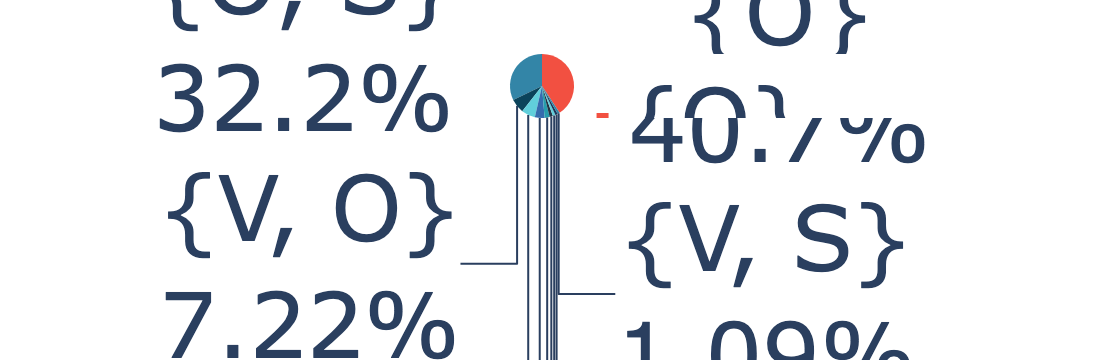

In [326]:
import plotly.express as px
from plotly.colors import label_rgb

names=[]
for name in dbb['disorder_set'].values:
    name_str=str(name).replace("'",'')
    names.append(name_str)
dbb['name']=names

colors=[(242/256, 80/256, 65/256),(11/256, 68/256, 91/256),'lightblue','mediumslateblue','b','royalblue','slateblue','dodgerblue','mediumpurple']

dbb.loc[dbb['percent(max)'] < 0.01, 'name'] = 'other sets' # Represent only large countries
fig = px.pie(dbb, values='percent(max)', names='name', color='name',
             color_discrete_map={"{O}": label_rgb((242, 80, 65)),
                                 "{O, S}": label_rgb((51, 133, 167)),
                                 "{V, O}": label_rgb((11, 68, 91)),
                                 "{V, O, S}": label_rgb((54, 108, 174)),
                                 "{S}": label_rgb((38, 157, 172)),
                                 "{O, VP}":label_rgb((34,51, 67)),
                                 "{O, VP, S}": label_rgb((97, 207, 219)),
                                 "{V, O, VP}": label_rgb((27,54,87)),
                                 "{V, S}": label_rgb((51, 133, 167)),
                                 'other sets':label_rgb((97, 207,219))
                                  })
fig.update_traces(textinfo='percent+label')
fig.update_layout(font=dict(size=90))
fig.write_image("images/set_with_no_duplicates1.png",width=15*300, height=10*300, scale=1)
fig.show()


In [37]:
np.sum(dbb['percent(max)'].values[:10]),np.sum(dbb['percent(min)'].values[:10])

(0.9396486467887654, 0.941998210792265)

In [327]:
length_min,list_of_sets_min=len_set(dbmin_struct['disorder_set'].values)
length_max,list_of_sets_max=len_set(dbmax_struct['disorder_set'].values)
for s in list_of_sets_max:
    if(s not in list_of_sets_min):
        print(s)

### 3. Coarse-graining

#### Non-intersecting classes

We defined aggregated classes as: <br>
S=({S}, {O, S}) <br>
V=({V}, {O, V}) <br>
P=({P}, {O, P}) <br>
M=(all other sets).

In [54]:
length,list_of_sets=len_set(dbmax_struct['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(dbmax_struct.loc[dbmax_struct['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size(max)']=len_dis
daa['percent(max)']=perc

daa=daa.sort_values(by=['size(max)'],ascending=False).reset_index(drop=True)
daa.head(7)

disorder_set  size(max)  percent(max)
0          {O}      41443      0.407418
1       {O, S}      32749      0.321949
2       {V, O}       7340      0.072158
3    {V, O, S}       4986      0.049016
4          {S}       2587      0.025432
5      {O, VP}       1721      0.016919
6   {O, VP, S}       1370      0.013468

In [55]:
slist=[{'S'},{'O','S'}]
vlist=[{'V'},{'O','V'},{'O','VP'}, {'O','V','VP'},{'V','VP'},{'VP'}]

In [56]:
num_o=daa.loc[daa['disorder_set']=={'O'}]['size(max)'].values[0]
num_o, num_o/np.sum(daa['size(max)'])

(41443, 0.40741833053155196)

In [57]:
num_s=np.sum(daa.loc[daa['disorder_set'].isin(slist)]['size(max)'])
num_s, num_s/np.sum(daa['size(max)'])

(35336, 0.3473815632956813)

In [58]:
num_v=np.sum(daa.loc[daa['disorder_set'].isin(vlist)]['size(max)'])
num_v, num_v/np.sum(daa['size(max)'])

(10482, 0.1030465685551656)

In [59]:
num_m=np.sum(daa['size(max)'])-num_o-num_s-num_v
num_m, num_m/np.sum(daa['size(max)'])

(14460, 0.14215353761760108)

In [60]:
data={'disorder class':["O ({O})","S ({S},{O,S})","V ({V},{V,O},{O,V,VP})",'M (all other)'],'size':[41443,35336,10482,14460],'fraction':[0.407,0.347,0.103,0.142]}

In [61]:
table=pd.DataFrame.from_dict(data)
table

disorder class   size  fraction
0                 O ({O})  41443     0.407
1           S ({S},{O,S})  35336     0.347
2  V ({V},{V,O},{O,V,VP})  10482     0.103
3           M (all other)  14460     0.142

#### Intersecting Classes

In [62]:
o_set=[]
for s in list_of_sets:
    if('O' in s):
        o_set.append(s)

In [63]:
num_o=np.sum(daa.loc[daa['disorder_set'].isin(o_set)]['size(max)'])
num_o, num_o/np.sum(daa['size(max)'])

(97092, 0.9544931725012534)

In [64]:
s_set=[]
for s in list_of_sets:
    if('S' in s):
        s_set.append(s)
    elif('SVP' in s):
        s_set.append(s)
    elif('SV' in s):
        s_set.append(s)

In [65]:
num_s=np.sum(daa.loc[daa['disorder_set'].isin(s_set)]['size(max)'])
num_s, num_s/np.sum(daa['size(max)'])

(49796, 0.4895351009132824)

In [71]:
v_set=[]
for s in list_of_sets:
    if('V' in s):
        v_set.append(s)
    elif('SV' in s):
        v_set.append(s)
    elif('VP' in s):
        v_set.append(s)
    elif('SVP' in s):
        v_set.append(s)

In [72]:
num_v=np.sum(daa.loc[daa['disorder_set'].isin(v_set)]['size(max)'])
num_v, num_v/np.sum(daa['size(max)'])

(24942, 0.2452001061727667)

In [73]:
p_set=[]
for s in list_of_sets:
    if('VP' in s):
        p_set.append(s)
    elif('SVP' in s):
        p_set.append(s)

In [74]:
num_p=np.sum(daa.loc[daa['disorder_set'].isin(p_set)]['size(max)'])
num_p, num_p/np.sum(daa['size(max)'])

(8716, 0.08568535503976564)

In [75]:
data={'disorder class':["O (all comounds with O)","S (all comounds with S, SV, SVP)","V (all compounds with V, SV, VP, SVP)",'P (all compounds with VP, SVP)'],'size':\
      [97092, 49796, 24942, 8716],'fraction':[0.954, 0.490, 0.245, 0.086]}
table=pd.DataFrame.from_dict(data)
table

disorder class   size  fraction
0                O (all comounds with O)  97092     0.954
1       S (all comounds with S, SV, SVP)  49796     0.490
2  V (all compounds with V, SV, VP, SVP)  24942     0.245
3         P (all compounds with VP, SVP)   8716     0.086

### Sunburst chart

In [76]:
dbb.head(30)

disorder_set  size(max)  percent(max)  size(min)  percent(min)  \
0                  {O}      41443      0.407418      42547      0.418272   
1               {O, S}      32749      0.321949      32578      0.320268   
2               {V, O}       7340      0.072158       7142      0.070212   
3            {V, O, S}       4986      0.049016       4938      0.048545   
4                  {S}       2587      0.025432       2532      0.024892   
5              {O, VP}       1721      0.016919       1486      0.014609   
6           {O, VP, S}       1370      0.013468       1315      0.012928   
7           {V, O, VP}       1290      0.012682       1206      0.011856   
8               {V, S}       1107      0.010883       1097      0.010784   
9              {SV, O}        989      0.009723        980      0.009634   
10          {SV, O, S}        772      0.007589        758      0.007452   
11       {V, O, VP, S}        700      0.006882        696      0.006842   
12            {O, SVP}        698      0.006862        647      0.006361   
13         {O, SVP, S}        603      0.005928        587      0.005771   
14          {SV, V, O}        502      0.004935        484      0.004758   
15         {V, O, SVP}        351      0.003451        343      0.003372   
16        {O, SVP, VP}        328      0.003225        299      0.002939   
17     {S, O, SVP, VP}        220      0.002163        196      0.001927   
18      {V, S, SVP, O}        205      0.002015        194      0.001907   
19     {V, O, SVP, VP}        200      0.001966        195      0.001917   
20             {S, VP}        197      0.001937        192      0.001888   
21       {SV, V, O, S}        162      0.001593        178      0.001750   
22             {SV, V}        125      0.001229        118      0.001160   
23  {S, SVP, V, O, VP}        110      0.001081        107      0.001052   
24                 {V}         89      0.000875         71      0.000698   
25      {SV, V, O, VP}         86      0.000845         88      0.000865   
26         {SV, O, VP}         75      0.000737         74      0.000727   
27          {SV, V, S}         70      0.000688         71      0.000698   
28             {SV, S}         69      0.000678         67      0.000659   
29          {V, S, VP}         68      0.000668         66      0.000649   

          name  
0          {O}  
1       {O, S}  
2       {V, O}  
3    {V, O, S}  
4          {S}  
5      {O, VP}  
6   {O, VP, S}  
7   {V, O, VP}  
8       {V, S}  
9   other sets  
10  other sets  
11  other sets  
12  other sets  
13  other sets  
14  other sets  
15  other sets  
16  other sets  
17  other sets  
18  other sets  
19  other sets  
20  other sets  
21  other sets  
22  other sets  
23  other sets  
24  other sets  
25  other sets  
26  other sets  
27  other sets  
28  other sets  
29  other sets

In [328]:
slist=[{'S'},{'O','S'}]
vlist=[{'V'},{'O','V'},{'O','VP'}, {'O','V','VP'},{'V','VP'},{'VP'}]
olist=[{'O'}]



a=dbb['disorder_set']
c=list(dbb['percent(max)'])
b=[]
for x in a:
    s=str(x)
    s=s.replace("'",'')
    b.append(s)

bb=['ICSD']
cc=[""]
xx=[1.0]
colors=[label_rgb((11, 68, 91))]
# colors=[label_rgb((54, 108, 174))]

bb.append('Ordered')
cc.append('ICSD')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'O'}]['percent(max)'].values))
colors.append(label_rgb((242, 80, 65)))

bb.append('Disordered')
cc.append('ICSD')
xx.append(sum(dbb.loc[dbb['disorder_set']!={'O'}]['percent(max)'].values))
colors.append(label_rgb((38, 157, 172)))

bb.append("O")
cc.append('Ordered')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'O'}]['percent(max)'].values))
colors.append('salmon')

bb.append('S')
cc.append('Disordered')
xx.append(sum(dbb.loc[dbb['disorder_set'].isin(slist)]['percent(max)'].values))
colors.append('purple')

bb.append('V')
cc.append('Disordered')
xx.append(sum(dbb.loc[dbb['disorder_set'].isin(vlist)]['percent(max)'].values))
colors.append('lightblue')

bb.append('M')
cc.append('Disordered')
xx.append(sum(dbb.loc[~dbb['disorder_set'].isin(olist+slist+vlist)]['percent(max)'].values))
colors.append('mediumslateblue')

bb.append('{S}')
cc.append('S')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'S'}]['percent(max)'].values))
colors.append('purple')

bb.append('{O, S}')
cc.append('S')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'S','O'}]['percent(max)'].values))
colors.append('purple')

bb.append('{V}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'V'}]['percent(max)'].values))
colors.append('lightblue')

bb.append('{V, O}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'V','O'}]['percent(max)'].values))
colors.append('lightblue')

bb.append('{V, O, VP}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'V','O', 'VP'}]['percent(max)'].values))
colors.append('lightblue')

bb.append('{O, VP}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'VP','O'}]['percent(max)'].values))
colors.append('lightblue')

for x in dbb['disorder_set'].values:
    if(x not in vlist+slist+olist):
        s=str(x)
        s=s.replace("'","")
        bb.append(s)
        cc.append('M')
        xx.append(sum(dbb.loc[dbb['disorder_set']==x]['percent(max)'].values))
        colors.append('mediumslateblue')



In [329]:
len(bb),len(cc),len(xx),len(colors)

(66, 66, 66, 66)

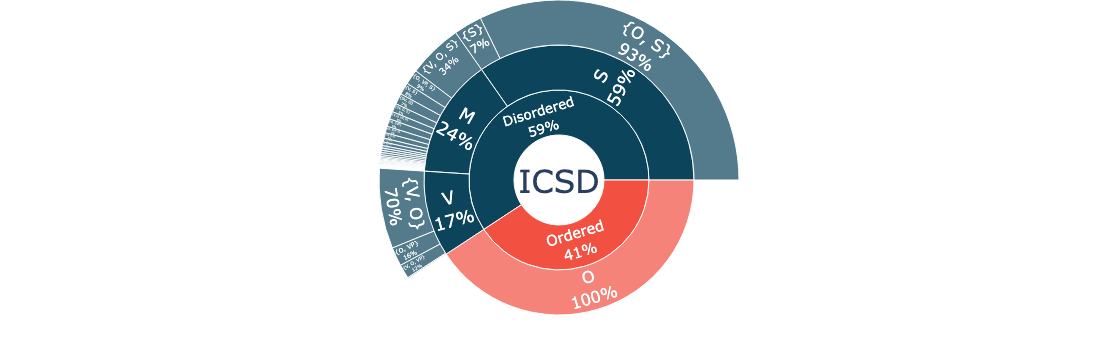

In [80]:
import plotly.express as px
data1 = dict(
    character=bb,
    parent=cc,
    value=xx)

fig = px.sunburst(
    data1,
    names='character',
    parents='parent',
    values='value',
    branchvalues="total", #template='plotly'
    color_discrete_sequence=colors
   
)

fig.update_layout(margin = dict(t=0, l=0, r=0, b=0),font=dict(size=100))
# fig.update_traces(textinfo="label+percent parent")
# color_discrete_sequence=px.colors.sequential.RdBu
fig.update_traces(textinfo="label+percent parent")
# fig.update_traces(textinfo='character+value')
# # fig.add_annotation(textangle=[0, 0, 0,0, 0, 0, 0, 0,0,0])
fig.write_image("images/set_with_no_duplicates_disordered.png",width=15*300, height=10*300, scale=1)
fig.show()

In [58]:
dcc=dbb.copy()

dis=[]
dis_class=[]
for i in dcc['disorder_set'].values:
    if(i=={'O'}):
        dis.append('Ordered')
        dis_class.append('O')
    else:
        dis.append('Disordered')
        if(i in slist):
            dis_class.append('S')
        elif(i in vlist):
            dis_class.append('V')
        elif(i in plist):
            dis_class.append('P')
        else:
            dis_class.append('M')
dcc['disorder']=dis
dcc['dis_class']=dis_class

a=dcc['disorder_set']
b=[]
for x in a:
    s=str(x)
    s=s.replace("'",'')
    b.append(s)
dcc['disorder_set']=b

In [59]:
dcc

disorder_set  size(max)  percent(max)  size(min)  \
0                              {O}      41370      0.406921    42419.0   
1                           {S, O}      32828      0.322900    32610.0   
2                           {O, V}       7349      0.072286     7132.0   
3                        {S, O, V}       4935      0.048541     4885.0   
4                              {S}       2597      0.025544     2542.0   
..                             ...        ...           ...        ...   
173             {O, VP, SP, SV, V}          1      0.000010        1.0   
174                {SVP, V, VP, P}          1      0.000010        1.0   
175  {SVP, O, VP, S, SP, P, SV, V}          1      0.000010        1.0   
176      {SVP, O, VP, S, SP, P, V}          1      0.000010        1.0   
177              {O, VP, P, SV, V}          1      0.000010        1.0   

     percent(min)        name    disorder dis_class  
0        0.417239         {O}     Ordered         O  
1        0.320756      {S, O}  Disordered         S  
2        0.070151      {O, V}  Disordered         V  
3        0.048049   {S, O, V}  Disordered         M  
4        0.025003         {S}  Disordered         S  
..            ...         ...         ...       ...  
173      0.000010  other sets  Disordered         M  
174      0.000010  other sets  Disordered         M  
175      0.000010  other sets  Disordered         M  
176      0.000010  other sets  Disordered         M  
177      0.000010  other sets  Disordered         M  

[178 rows x 8 columns]

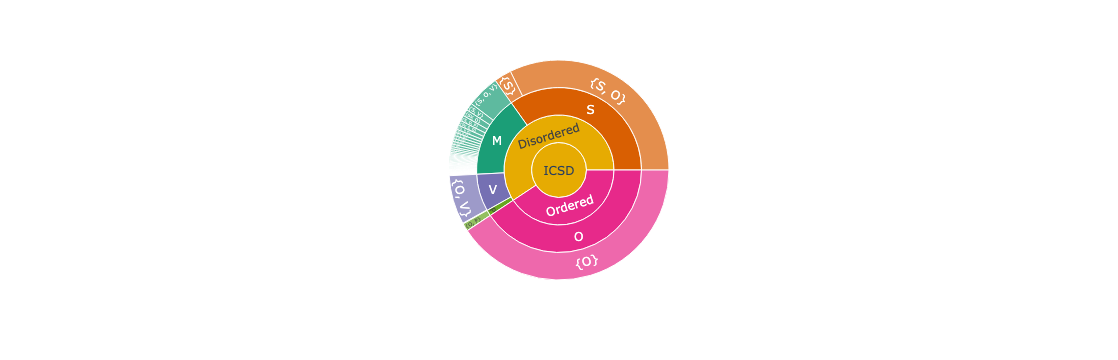

In [60]:
import plotly.express as px

fig = px.sunburst(dcc, path=[px.Constant("ICSD"),'disorder', 'dis_class', 'disorder_set'], values='percent(max)',\
                  color='dis_class',color_discrete_sequence=px.colors.qualitative.Dark2)
fig.show()

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/3211802344.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



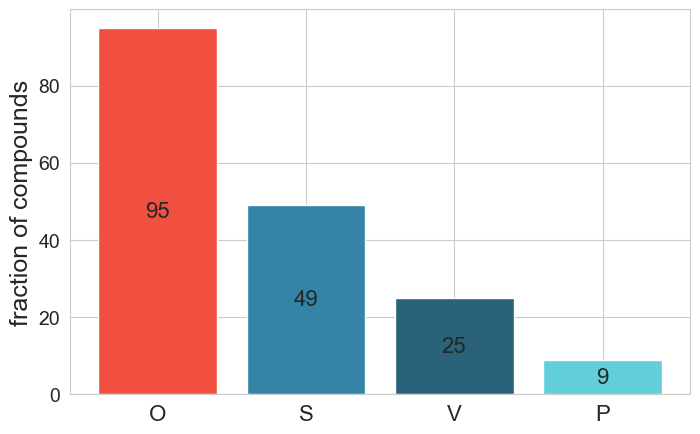

In [330]:
names=['O','S','V','P']
percent=[0,0,0,0]
inter_class_O=[]
inter_class_S=[]
inter_class_V=[]
inter_class_P=[]
for i in range(len(dbb)):
    if('O' in dbb.iloc[i]['disorder_set']):
        percent[0]+=dbb.iloc[i]['percent(max)']
        inter_class_O.append(True)
    else:
        inter_class_O.append(False)
    if(('S' in dbb.iloc[i]['disorder_set']) or ('SV' in dbb.iloc[i]['disorder_set']) or\
       ('SP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[1]+=dbb.iloc[i]['percent(max)']
        inter_class_S.append(True)
    else:
        inter_class_S.append(False)
    if(('V' in dbb.iloc[i]['disorder_set']) or ('SV' in dbb.iloc[i]['disorder_set']) or\
       ('VP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[2]+=dbb.iloc[i]['percent(max)']
        inter_class_V.append(True)
    else:
        inter_class_V.append(False)
    if(('P' in dbb.iloc[i]['disorder_set']) or ('SP' in dbb.iloc[i]['disorder_set']) or\
       ('VP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[3]+=dbb.iloc[i]['percent(max)']
        inter_class_P.append(True)
    else:
        inter_class_P.append(False)
for i in range(4):
    percent[i]=round(percent[i],2)*100

fig, ax = plt.subplots(figsize=(8,5))
p = ax.bar(names, percent, width=0.8, label=percent, color=[(242/256, 80/256, 65/256),(51/256, 133/256, 167/256),(41/256, 98/256, 121/256),(97/256, 207/256,219/256)])
ax.bar_label(p, label_type='center',fontsize=16)
ax.set_xticklabels(labels=names,fontsize=16)
plt.ylabel('fraction of compounds',fontsize=18)
plt.yticks(fontsize=14)
plt.savefig("images/intersecting_classes.png", transparent=True, dpi=400, format='png')
plt.show()

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/2091814001.py:26: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



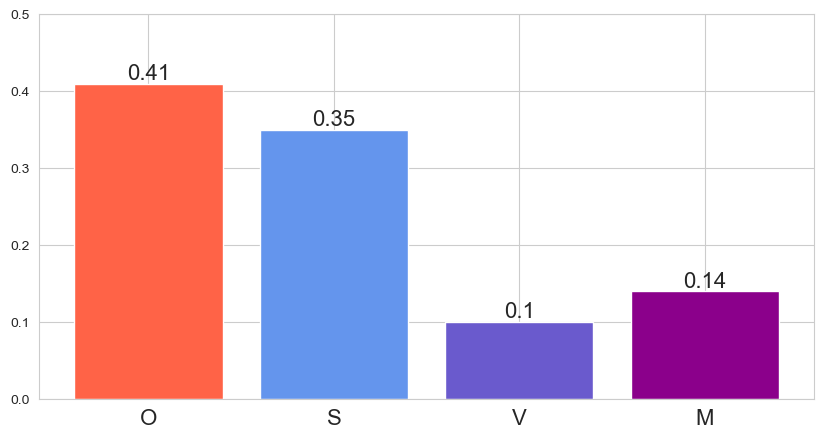

In [331]:
slist=[{'S','O'},{'S'}]
vlist=[{'V','O'},{'V'},{'VP'},{'V','VP'},{'O','VP'},{'O','V','VP'}]
olist=[{'O'}]

names=['O','S','V','M']
percent=[0,0,0,0]
non_intersecting_class=[]
for i in range(len(dbb)):
    if(dbb.iloc[i]['disorder_set'] in olist):
        percent[0]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('O')
    elif(dbb.iloc[i]['disorder_set'] in slist):
        percent[1]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('S')
    elif(dbb.iloc[i]['disorder_set'] in vlist):
        percent[2]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('V')
    else:
        percent[3]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('M')
for i in range(4):
    percent[i]=round(percent[i],2)
fig, ax = plt.subplots(figsize=(10,5))
p = ax.bar(names, percent, width=0.8, label=percent, color=['tomato','cornflowerblue','slateblue','darkmagenta'])
ax.bar_label(p,fontsize=16)
ax.set_xticklabels(labels=names,fontsize=16)
plt.ylim(0,0.5)
# plt.savefig("images/non-intersecting_classes.png", transparent=True, dpi=400, format='png')

plt.show()

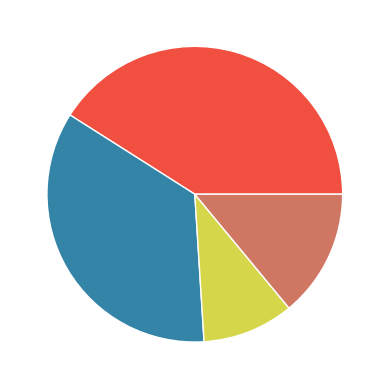

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
# fig, ax = plt.subplots(figsize=(8,5))
fractions = [0.41,0.35,0.1,0.14]
classes = ['O','S','V','M']

# Explode Shoes slice
# explode = [0.1, 0, 0, 0, 0,0, 0]
sns.set_style("whitegrid")
# Create pie chart
plt.pie(fractions,colors=[(242/256, 80/256, 65/256),(51/256, 133/256, 167/256),\
                          (215/256, 215/256, 74/256),(209/256, 119/256, 99/256)])

# plt.setp(autotexts, size=8, weight="bold")
# plt.label(p, label_type='center',fontsize=16)
# Show plot
plt.savefig("images/pie-orbitrary.png", transparent=True, dpi=400, format='png')
plt.show()

# Global order/disorder

In [92]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=dbmax_struct.loc[dbmax_struct['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o)/10000)
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d)/10000)
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)


In [93]:
len(dbmax_struct)

101721

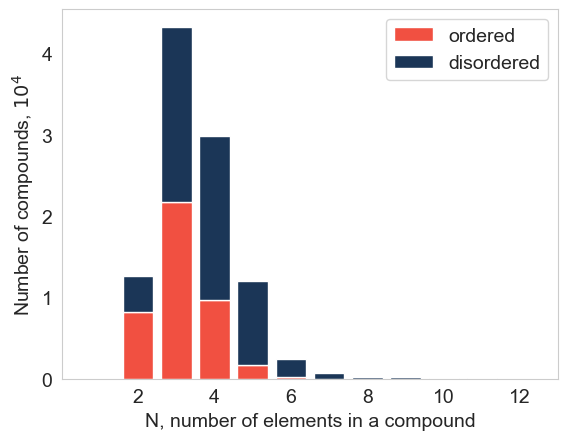

In [95]:
plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(242/256, 80/256, 65/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(27/256,54/256,87/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of compounds, $10^4$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=False)
# plt.yscale('log')
plt.legend(fontsize=14)
plt.savefig('images/comp_distr.png', transparent=None, dpi=400, format='png')
plt.show()

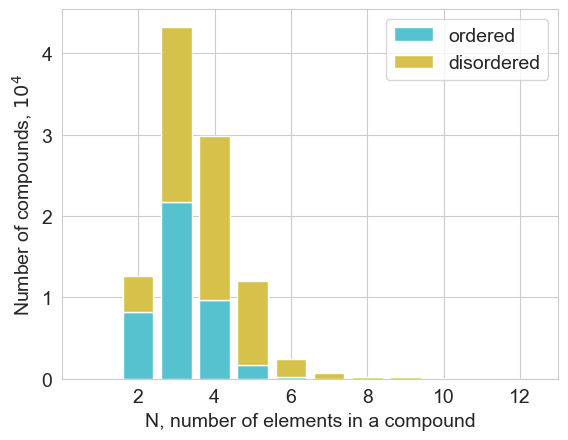

In [275]:
plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of compounds, $10^4$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

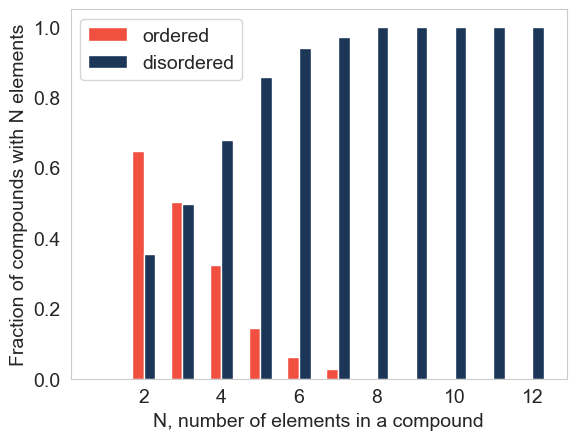

In [96]:
plt.bar(np.linspace(1-0.15,12-0.15,12),ordered[:-2],width=0.3,label='ordered',color=(242/256, 80/256, 65/256))
plt.bar(np.linspace(1+0.15,12+0.15,12),disordered[:-2],width=0.3,label='disordered',color=(27/256,54/256,87/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Fraction of compounds with N elements',fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=False)
plt.savefig('images/order-vs-disorder.png', transparent=None, dpi=400, format='png')
plt.show()

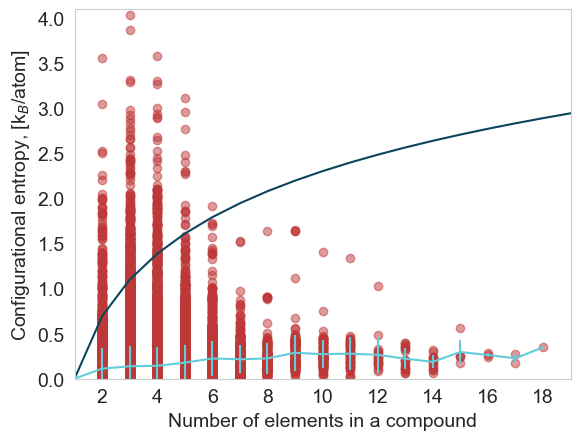

In [104]:
means=[0]
stds=[0]

dbmax_nona=dbmax_struct.loc[~dbmax_struct['entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['entropy']<100]
dbmax_nona=dbmax_nona.loc[dbmax_nona['entropy']>=0]
for n in range(2,31):
    ent=dbmax_nona.loc[dbmax_nona['num_el']==n]['entropy'].values
    means.append(np.mean(ent))
    stds.append(np.std(ent))

plt.scatter(dbmax_nona['num_el'], dbmax_nona['entropy'], alpha=0.5,color=(192/256, 56/256, 56/256))
plt.errorbar(np.linspace(1,30,30), means, yerr=stds, alpha=1,color=(97/256, 207/256, 219/256))

# plt.bar(np.linspace(1,14,14), stds, alpha=0.5, width=0.3)
plt.plot(np.linspace(1,30,30), np.log(np.linspace(1,30,30)),color=(11/256, 69/256, 92/256))

plt.xlim(1,19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
plt.ylim(0,4.1)
plt.xlabel('Number of elements in a compound',fontsize=14)
plt.ylabel('Configurational entropy, [k$_B$/atom]', fontsize=14)
plt.grid(visible=False)
plt.savefig('images/entropy-num-elem.png', transparent=None, dpi=400, format='png')
plt.show()

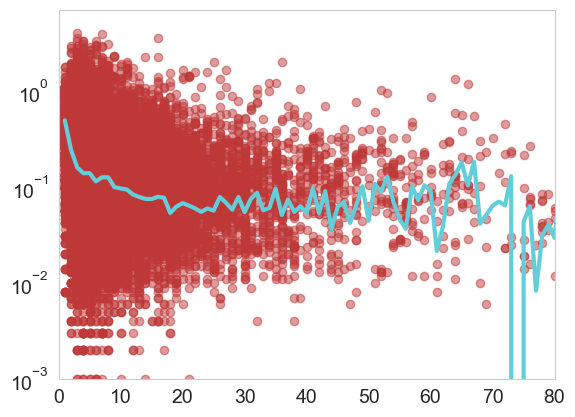

In [117]:
means=[]
stds=[]

dbmax_nona=dbmax_struct.loc[~dbmax_struct['entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['entropy']<100]
for n in range(1,101):
    ent=dbmax_nona.loc[dbmax_nona['num_orb']==n]['entropy'].values
    means.append(np.mean(ent))
    stds.append(np.std(ent))

plt.scatter(dbmax_nona['num_orb'], dbmax_nona['entropy'].values, alpha=0.5,color=(192/256, 56/256, 56/256))
# plt.bar(np.linspace(1,200,200), means, alpha=1, width=0.3)
# plt.errorbar(np.linspace(1,100,100), means, yerr=stds, alpha=1,color=(97/256, 207/256, 219/256))
plt.plot(np.linspace(1,100,100), means, alpha=1,color=(97/256, 207/256, 219/256),linewidth=3)
plt.xlim(0,80)
plt.ylim(0.001,7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.grid(visible=False)
# plt.ylim(0,3.7)
# plt.xlabel('Number of orbits in a compound',fontsize=14)
# plt.ylabel('Configurational entropy, [$k_B$/atom]', fontsize=14)
plt.yscale('log')
plt.savefig('images/entropy-num-orbits-log.png', transparent=None, dpi=400, format='png')
plt.show()

/Users/elenapatyukova/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/elenapatyukova/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



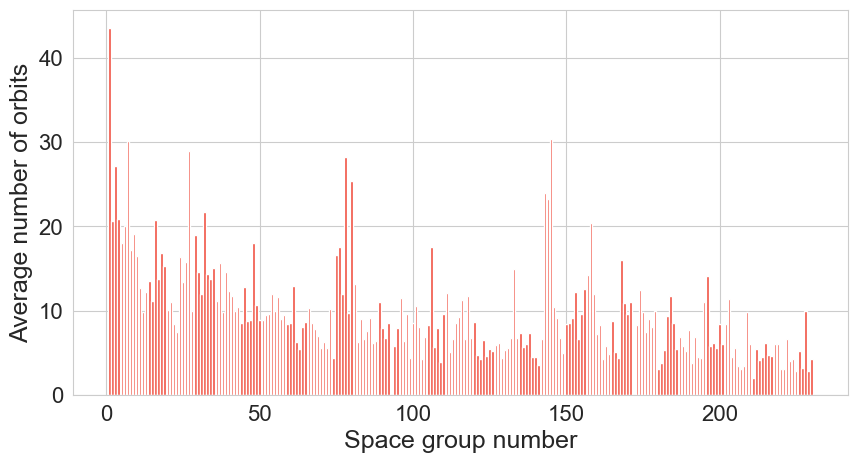

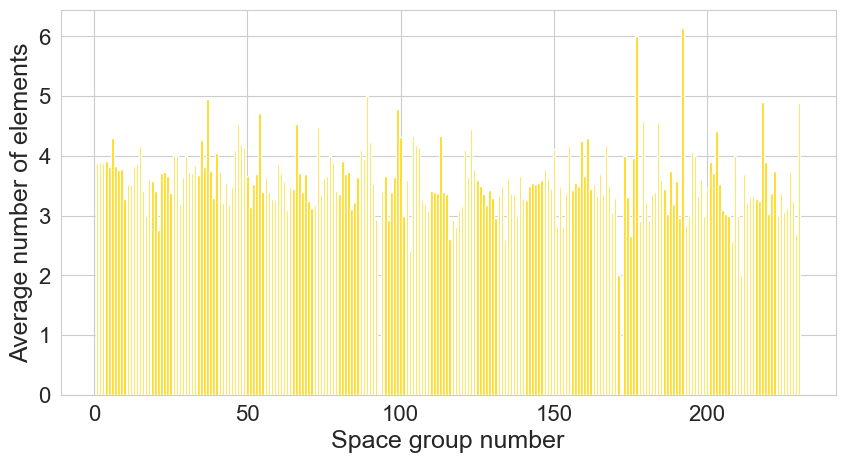

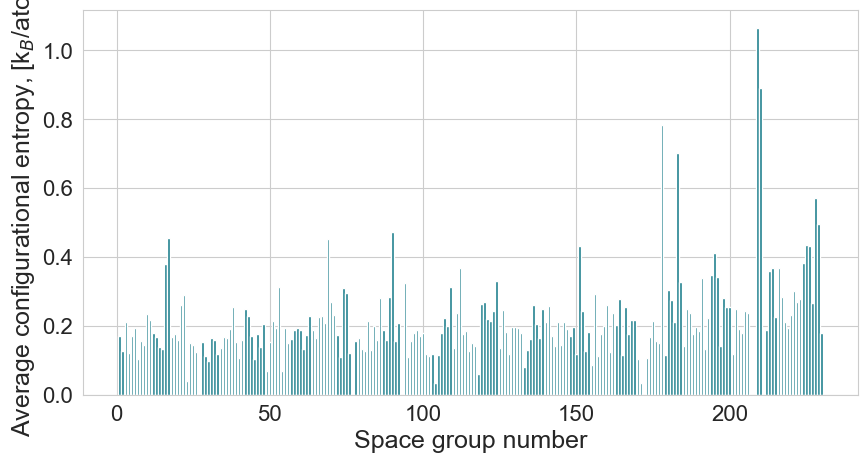

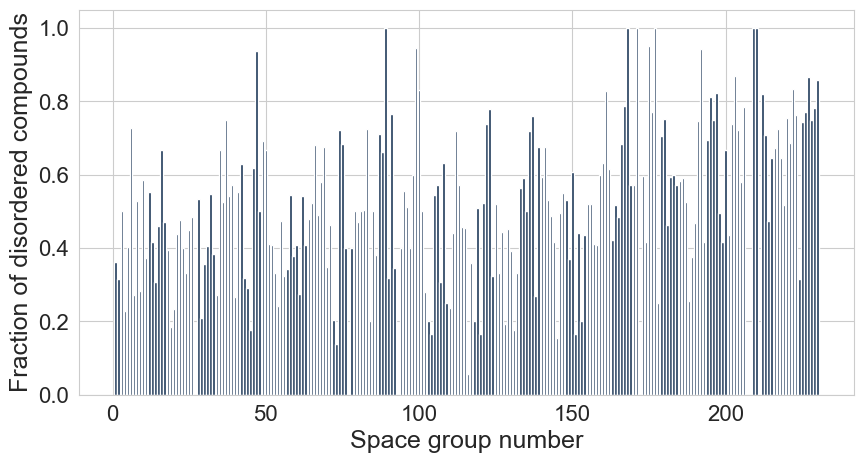

In [272]:
dbmax_nona=dbmax_struct.loc[~dbmax_struct['entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['entropy']<100]
space_groups=np.linspace(1,230,230,dtype='int')

space_num_orb=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    space_num_orb.append(np.mean(dx['num_orb'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_orb,color=(242/256, 80/256, 65/256))
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average number of orbits', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=True)
plt.savefig('images/av-orbits-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_num_elem=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    space_num_elem.append(np.mean(dx['num_el'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_elem,color='gold')
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average number of elements', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=True)
plt.savefig('images/av-elem-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_num_entropy=[]
dbmax_nona1=dbmax_nona.loc[dbmax_nona['disorder_set']!={'O'}]
for group in space_groups:
    dx=dbmax_nona1.loc[dbmax_nona1['group_num']==group]
    space_num_entropy.append(np.mean(dx['entropy'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_entropy,color=(31/256, 129/256, 142/256))
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average configurational entropy, [k$_B$/atom]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=True)
plt.savefig('images/av-entropy-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_frac_dis=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    if(len(dx)>0):
        space_frac_dis.append(len(dx.loc[dx['disorder_set']!={'O'}])/len(dx))
    else:
        space_frac_dis.append(0)

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_frac_dis,color=(27/256,54/256,87/256))
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Fraction of disordered compounds', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=True)
plt.savefig('images/frac-order-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

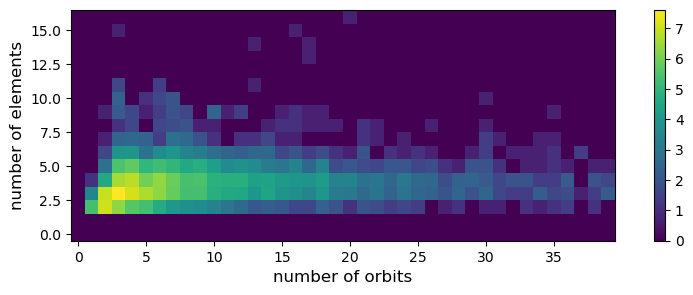

In [79]:
orb_vs_el=np.zeros((17,40))

for i in range(40):
    for j in range(17):
        dx=dbmax_struct.loc[dbmax_struct['num_orb']==i]
        dy=dx.loc[dx['num_el']==j]
        orb_vs_el[j,i]=np.log(1+len(dy))

plt.figure(figsize=(10,3))
plt.imshow(orb_vs_el,origin='lower')
plt.colorbar()
plt.xlabel('number of orbits',fontsize=12)
plt.ylabel('number of elements',fontsize=12)
plt.show()

In [332]:
orb_el_comp=[]
for i in range(len(dbmax_struct)):
    comp_el=[]
    for i,orb in dbmax_struct.iloc[i]['species'].items():
        c_el=[]
        comp=Composition(orb).element_composition.elements
        for el in comp:
            c_el.append(str(el))
        comp_el.append(c_el)
    orb_el_comp.append(comp_el)


In [333]:
dbmax_struct['orbit_elements_comp']=orb_el_comp

# Distribution of disorder over the elements


### General distribution over elements

In [334]:
elem_list=['Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P',
           'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

In [335]:
len(elem_list)

96

In [336]:
element_disorder=dbmax_struct[['ICSD_ID','formula','disorder_set','orbit_disorder','orbit_elements_comp']]

In [337]:
def calculate_elements(elem_list,element_disorder):
    elem_disorder={}
    
    for key in elem_list:
        # the correspondence between the number in element vector and disorder is 
        # [O-0,S-1,V-2,SV-3,VP-4,SVP-5]
        elem_disorder[key]=np.zeros(6)
    for i in range(len(element_disorder)):
        order=element_disorder['orbit_disorder'].values[i]
        elem=element_disorder['orbit_elements_comp'].values[i]
        elem_dict={}
        for j,el_list in enumerate(elem):
            for el in el_list:
                if(el in elem_dict.keys()):
                    elem_dict[el].append(order[str(j)])
                else:
                    elem_dict[el]=[order[str(j)]]
        for key in elem_dict.keys():
            states=list(set(elem_dict[key]))
            switch={'O':0,'S':0,'P':0,'V':0,'SV':0,'SP':0,'VP':0,'SVP':0}
            for s in states:
                if(key in elem_list):
                    if(s=='O' and switch['O']==0):
                        elem_disorder[key][0]+=1
                        switch['O']=1
                    elif(s=='S' and switch['S']==0):
                        elem_disorder[key][1]+=1
                        switch['S']=1
                    elif(s=='V' and switch['V']==0):
                        elem_disorder[key][2]+=1
                        switch['V']=1
                    elif(s=='SV' and switch['SV']==0):
                        elem_disorder[key][3]+=1
                        switch['P']=1
                    elif(s=='VP' and switch['VP']==0):
                        elem_disorder[key][4]+=1
                        switch['SV']=1
                    elif(s=='SVP' and switch['SVP']==0):
                        elem_disorder[key][5]+=1
                        switch['SP']=1

    elem_disorder_frac={}
    total_values=[]
    frac_values=[]
    for key in elem_disorder.keys():
        elem_disorder_frac[key]=np.zeros(7)
        elem_disorder_frac[key][0]=np.sum(elem_disorder[key])
        total_values.append(elem_disorder_frac[key][0])
        if(elem_disorder_frac[key][0]!=0):
            for i in range(1,7):
                elem_disorder_frac[key][i]=elem_disorder[key][i-1]/elem_disorder_frac[key][0]
        frac_values.append(elem_disorder_frac[key][1:7])
    
    return elem_disorder, elem_disorder_frac

In [338]:
elem_disorder, elem_disorder_frac=calculate_elements(elem_list,element_disorder)

In [339]:
def bars_fill(elem_disorder,frac=True):
    bars=np.zeros((6,len(elem_disorder.keys())))
    total=[]
    names=[]
    r=[]
    for i,key in enumerate(elem_disorder.keys()):
        names.append(key)
        if(frac==True):
            for j in range(0,6):
                bars[j,i]=elem_disorder[key][1+j]
        else:
            for j in range(0,6):
                bars[j,i]=elem_disorder[key][j]
            
        total.append(int(np.sum(elem_disorder[key])))
        r.append(i)
    bottom3=np.zeros((4,len(elem_disorder.keys())))
    bottom3[0,:]=bars[0,:]+bars[1,:]
    for i in range(3):
        bottom3[i+1,:]=bottom3[i,:]+bars[i+2,:]
    return bars, total, names, r, bottom3

In [340]:
def plot_elements(elem_disorder,filename, n=58, frac=True,barWidth=1): 
    bars, total, names, r, bottom3 = bars_fill(elem_disorder,frac)
    
    
    if(frac==True):
        caption='fraction of compounds'
    else:
        caption='number of compounds'
    
    plt.figure(figsize=(15,10))

    # Create brown bars
    ax1=plt.subplot(211)
    ax2=ax1.twiny()
    
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[0,:n], color=(242/256, 80/256, 65/256), edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[1,:n], bottom=bars[0,:n], color=(51/256, 120/256, 170/256), edgecolor='white', width=barWidth,label='S')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[2,:n], bottom=bottom3[0,:n], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label='V')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[3,:n], bottom=bottom3[1,:n], color=(229/256, 226/256, 89/256), edgecolor='white', width=barWidth,label='SV')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[4,:n], bottom=bottom3[2,:n], color=(209/256, 119/256, 99/256), edgecolor='white', width=barWidth,label='VP')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[5,:n], bottom=bottom3[3,:n], color=(192/256, 56/256, 56/256), edgecolor='white', width=barWidth,label='SVP') 

    # Custom X axis
    ax1.set_xticks(r[:n]+0.5*np.ones(len(r[:n])), names[:n], fontweight='bold',fontsize=10)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=16)
    ax1.grid(visible=False,axis='both')

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(r[:n]+0.5*np.ones(len(r[:n])))
    ax2.set_xticklabels(total[:n],rotation='vertical')
    ax2.grid(visible=False)
#     ax1.legend()

    ax1=plt.subplot(212)
    ax2=ax1.twiny()
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[0,n:], color=(242/256, 80/256, 65/256), edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[1,n:], bottom=bars[0,n:], color=(51/256, 120/256, 170/256), edgecolor='white', width=barWidth,label='S')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[2,n:], bottom=bottom3[0,n:], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label='V')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[3,n:], bottom=bottom3[1,n:], color=(229/256, 226/256, 89/256), edgecolor='white', width=barWidth,label='SV')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[4,n:], bottom=bottom3[2,n:], color=(209/256, 119/256, 99/256), edgecolor='white', width=barWidth,label='VP')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[5,n:], bottom=bottom3[3,n:], color=(192/256, 56/256, 56/256), edgecolor='white', width=barWidth,label='SVP') 

    # Custom X axis
    ax1.set_xticks(r[n:]+0.5*np.ones(len(r[n:])), names[n:], fontweight='bold',fontsize=10)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=16)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(r[n:]+0.5*np.ones(len(r[n:])))
    ax2.set_xticklabels(total[n:],rotation='vertical')
    ax2.grid(visible=False)
    ax1.grid(visible=False,axis='both')
    ax1.legend()
    # Show graphic
    path='images/'
    plt.savefig(filename, transparent=None, dpi=400, format='png')
    plt.show()

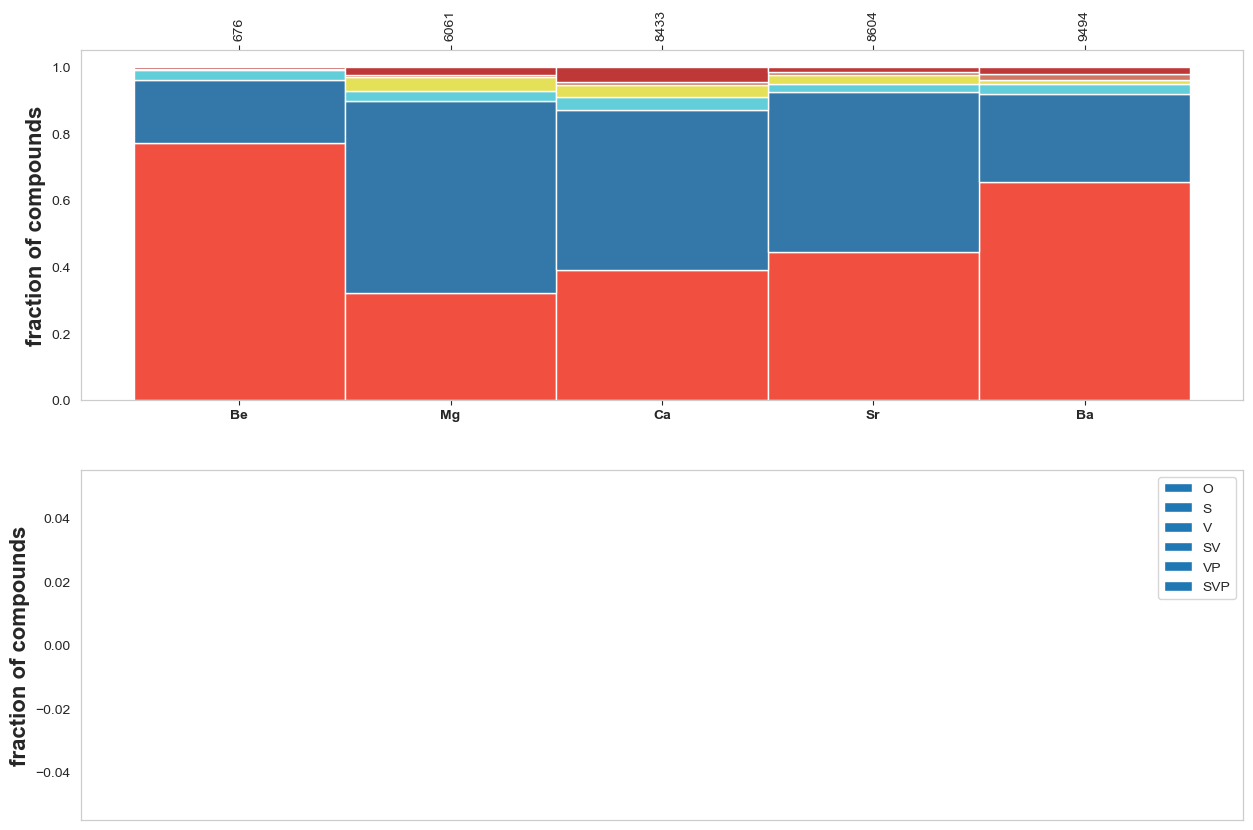

In [224]:
plot_elements(elem_disorder_frac,filename='distr-over-elements.png', n=48, frac=True,barWidth=1)

In [341]:
symbol = [['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
         ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
         ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
         ['K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
         ['Rb ', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe' ],
         ['Cs', 'Ba', '', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn' ],
         ['Fr', 'Ra', '', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'],
         ['', '', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ''],
         ['', '', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', '' ]]

color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][1])
        else:
            line_color.append(0)
    color.append(line_color)

In [342]:
len(color),len(symbol)

(9, 9)

In [343]:
len(elem_disorder_frac['O']),elem_disorder_frac['O']

(7,
 array([5.24620000e+04, 8.16571995e-01, 1.82989592e-02, 1.07201403e-01,
        3.37387061e-03, 4.77679082e-02, 6.78586405e-03]))

In [344]:
import matplotlib as mlt

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mlt.colors.to_rgb(c1))
    c2=np.array(mlt.colors.to_rgb(c2))
    return mlt.colors.to_hex((1-mix)*c1 + mix*c2)

def create_colorscale(c1,c2,n):
    c1=np.array(c1)
    c2=np.array(c2)
    y=np.linspace(0,1,n)
    colorscale=[[0,'rgb(255,255,255)']]
    for xx in y[1:]:
        c=c1*(1-xx)+xx*c2
        c='rgb'+str(tuple(c))
        colorscale.append([xx,c])
    return colorscale

In [345]:
# Periodic Table Data
symbol = [['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
         ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
         ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
         ['K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
         ['Rb ', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe' ],
         ['Cs', 'Ba', '', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn' ],
         ['Fr', 'Ra', '', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'],
         ['', '', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ''],
         ['', '', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', '' ]]
      

element = [['Hydrogen', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Helium'],
           ['Lithium', 'Beryllium', '', '', '', '', '', '', '', '', '', '', 'Boron', 'Carbon', 'Nitrogen', 'Oxygen', 'Fluorine', 'Neon'],
           ['Sodium', 'Magnesium', '', '', '', '', '', '', '', '', '', '', 'Aluminium', 'Silicon', 'Phosphorus', 'Sulfur', 'Chlorine', 'Argon'],
           ['Potassium', 'Calcium', 'Scandium', 'Titanium', 'Vanadium', 'Chromium',  'Manganese', 'Iron', 'Cobalt', 'Nickel', 'Copper', 'Zinc', 'Gallium', 'Germanium', 'Arsenic', 'Selenium', 'Bromine', 'Krypton'],
           ['Rubidium', 'Strontium', 'Yttrium', 'Zirconium', 'Niobium', 'Molybdenum', 'Technetium', 'Ruthenium', 'Rhodium', 'Palladium', 'Silver', 'Cadmium', 'Indium', 'Tin', 'Antimony', 'Tellurium', 'Iodine', 'Xenon'],
           ['Cesium', 'Barium', '',  'Hafnium', 'Tantalum', 'Tungsten', 'Rhenium', 'Osmium', 'Iridium', 'Platinum', 'Gold', 'Mercury', 'Thallium', 'Lead', 'Bismuth', 'Polonium', 'Astatine', 'Radon'],
           ['Francium', 'Radium', '', 'Rutherfordium','Dubnium','Seaborgium','Bohrium','Hassium','Meitnerium','Darmstadtium','Roentgenium','Copernicium','Ununtrium','Ununquadium','Ununpentium','Ununhexium','Ununseptium','Ununoctium'],
           ['', '',  'Lanthanum', 'Cerium', 'Praseodymium', 'Neodymium', 'Promethium', 'Samarium', 'Europium', 'Gadolinium', 'Terbium', 'Dysprosium', 'Holmium', 'Erbium', 'Thulium', 'Ytterbium', 'Lutetium', ''],
           ['', '', 'Actinium', 'Thorium', 'Protactinium', 'Uranium', 'Neptunium', 'Plutonium', 'Americium', 'Curium', 'Berkelium', 'Californium', 'Einsteinium','Fermium' ,'Mendelevium', 'Nobelium', 'Lawrencium', '' ]]

atomic_mass = [[ 1.00794, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  4.002602],
     [ 6.941, 9.012182, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  10.811, 12.0107, 14.0067, 15.9994, 18.9984032, 20.1797],
     [ 22.98976928, 24.3050, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  26.9815386, 28.0855, 30.973762, 32.065, 35.453, 39.948],
     [ 39.0983, 40.078, 44.955912, 47.867, 50.9415, 51.9961, 54.938045, 55.845, 58.933195, 58.6934, 63.546, 65.38, 69.723, 72.64, 74.92160, 78.96, 79.904, 83.798],
     [ 85.4678, 87.62, 88.90585, 91.224, 92.90638, 95.96, 98, 101.07, 102.90550, 106.42, 107.8682, 112.411, 114.818, 118.710, 121.760, 127.60, 126.90447, 131.293],
     [ 132.9054519, 137.327, .0, 178.49, 180.94788, 183.84, 186.207, 190.23, 192.217, 195.084, 196.966569, 200.59, 204.3833, 207.2, 208.98040, 209, 210, 222],
     [223, 226, .0, 267, 268, 271, 272, 270, 276, 281, 280, 285, 284, 289, 288, 293, 'unknown', 294],
     [.0, .0, 138.90547, 140.116, 140.90765, 144.242, 145, 150.36, 151.964, 157.25, 158.92535, 162.500, 164.93032, 167.259, 168.93421, 173.054, 174.9668, .0],
     [.0, .0, 227, 232.03806, 231.03588, 238.02891, 237, 244, 243, 247, 247, 251, 252, 257, 258, 259, 262, .0]]

colorscale=create_colorscale((27, 54, 87),(242, 80, 65),50)

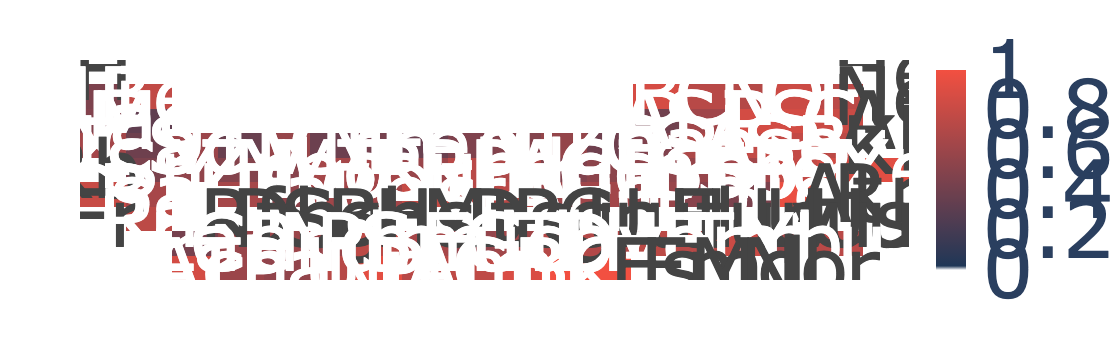

In [139]:
import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=colorscale, aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/disorder_elements.png",width=15*300, height=10*300, scale=1)

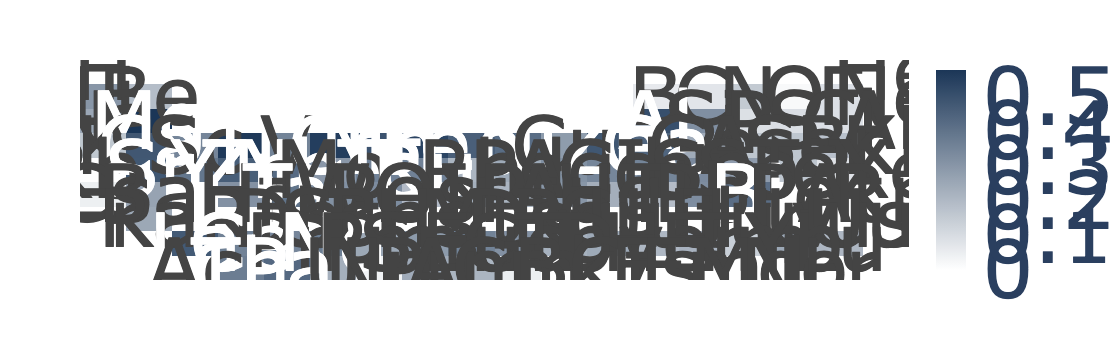

In [140]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][2])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((255,255,255),(27,54,87),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/S_elements.png",width=15*300, height=10*300, scale=1)

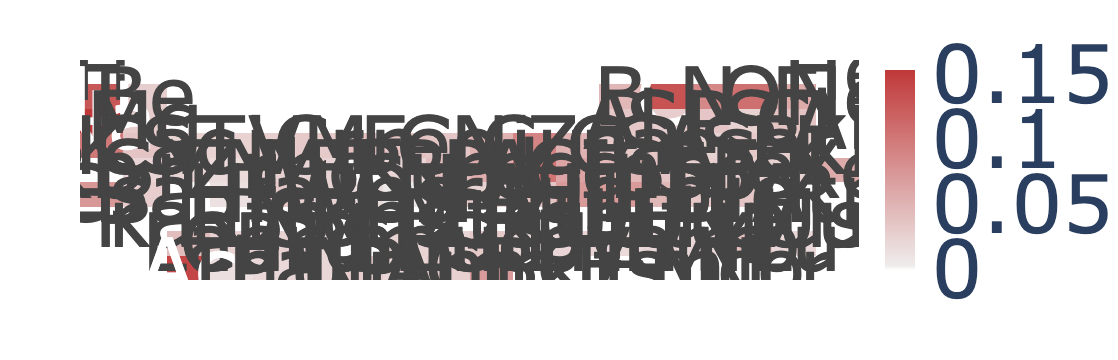

In [353]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][3])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(192,56,56),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/V_elements.png",width=15*300, height=10*300, scale=1)

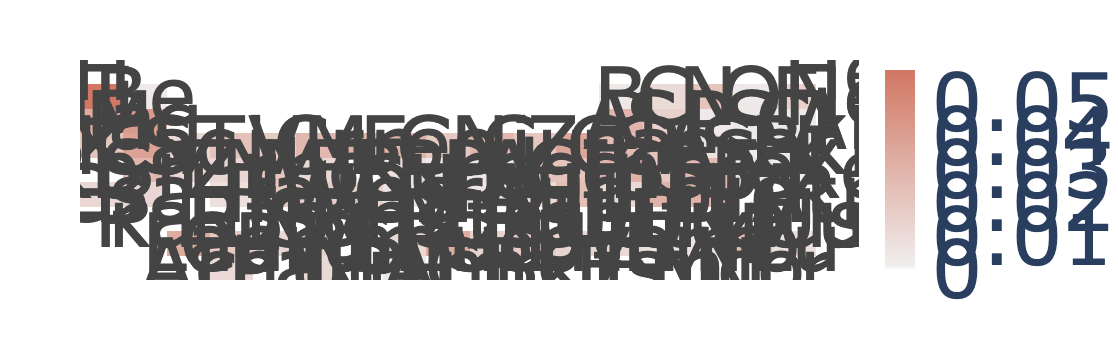

In [351]:
import matplotlib as mlt
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][4])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(209, 119, 99),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/SV_elements.png",width=15*300, height=10*300, scale=1)

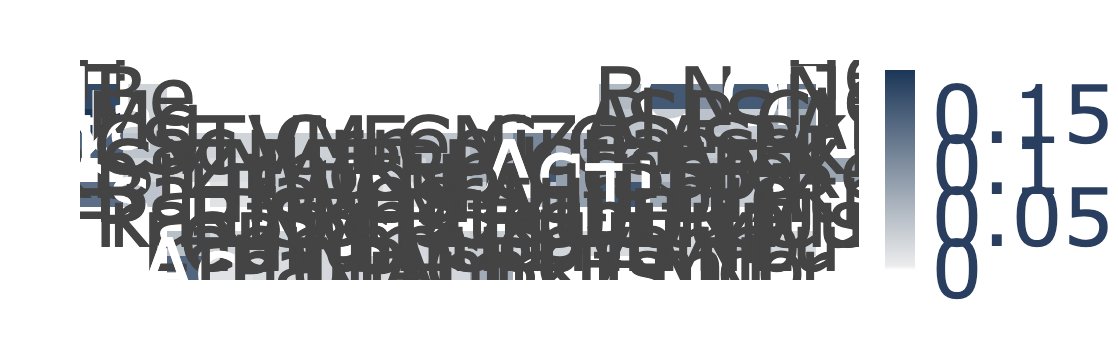

In [346]:
# V + VP disorder

import matplotlib as mlt
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][3]+elem_disorder_frac[sym][5])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(27, 54, 87),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/V+VP_elements.png",width=15*300, height=10*300, scale=1)

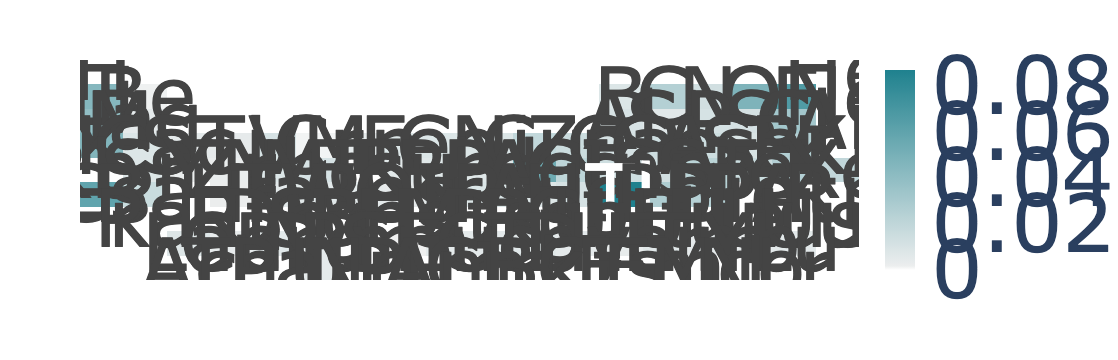

In [354]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][5])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(31, 129, 142),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/VP_elements.png",width=15*300, height=10*300, scale=1)

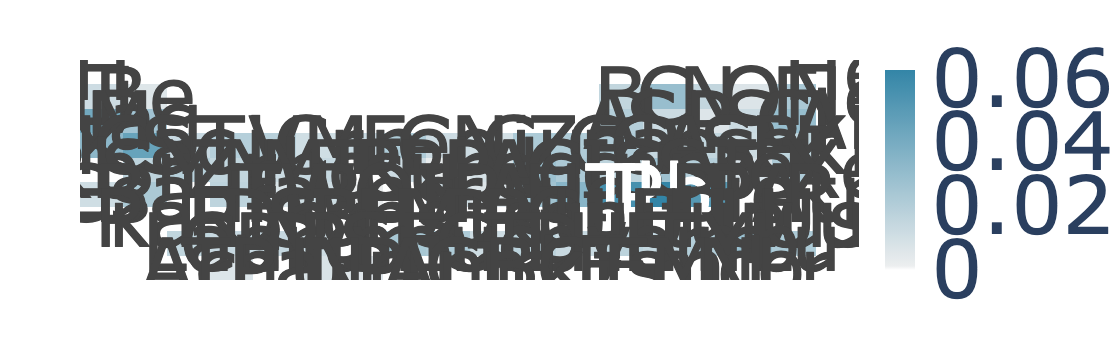

In [144]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][6])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(51, 133, 167),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/SVP_elements.png",width=15*300, height=10*300, scale=1)

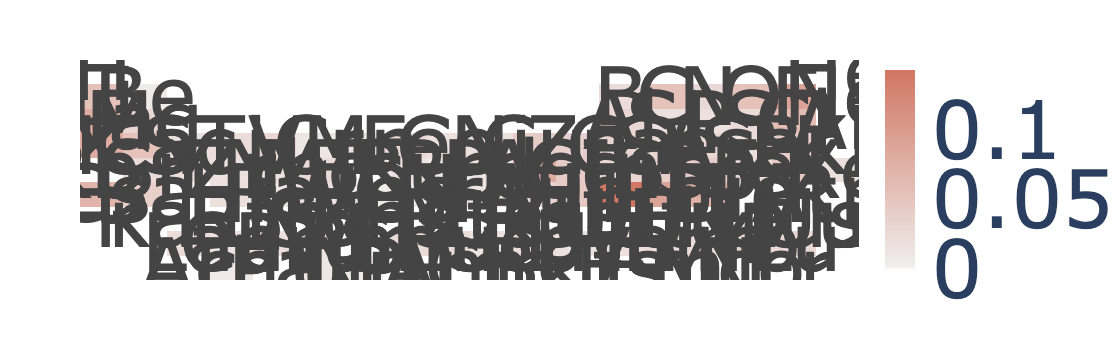

In [348]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][5]+elem_disorder_frac[sym][6])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(209, 119, 99),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/VP+SVP_elements.png",width=15*300, height=10*300, scale=1)

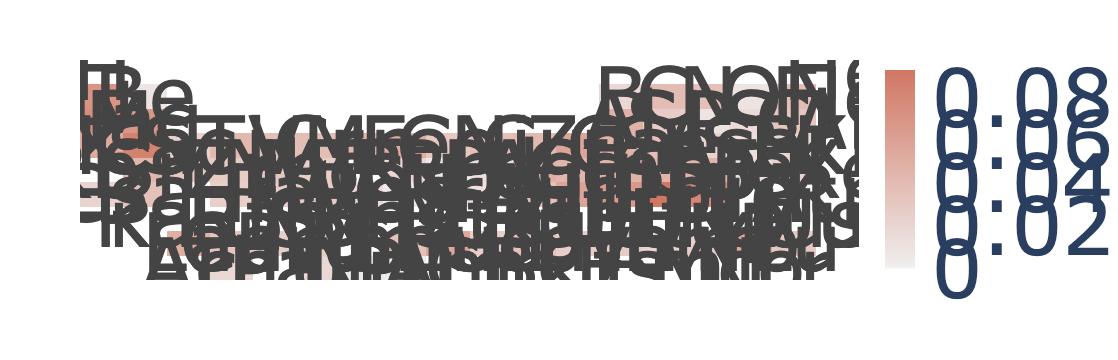

In [349]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][4]+elem_disorder_frac[sym][6])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(209, 119, 99),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/SV+SVP_elements.png",width=15*300, height=10*300, scale=1)

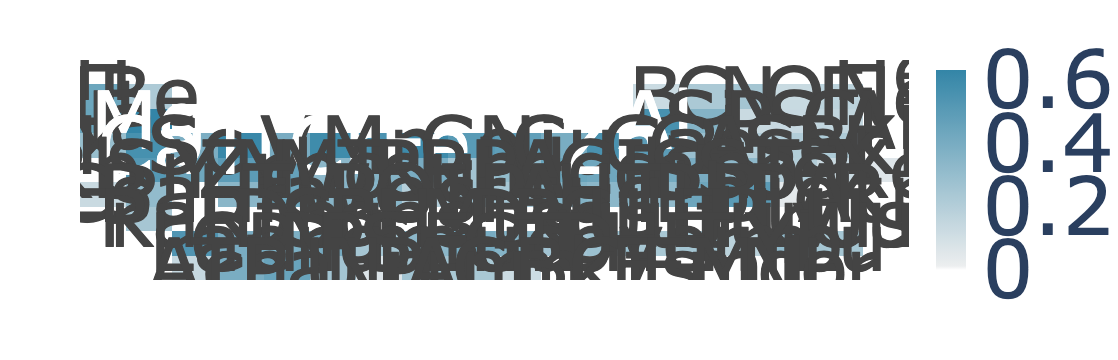

In [350]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][2]+elem_disorder_frac[sym][3]+elem_disorder_frac[sym][6])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(51, 133, 167),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=80,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/S+SV+SVP_elements.png",width=15*300, height=10*300, scale=1)

In [98]:
drank_frac=pd.DataFrame.from_dict(elem_disorder_frac, orient='index', dtype=None, columns=None)
drank_frac1=drank_frac.loc[drank_frac[0]>300]

drankT=pd.DataFrame()
for i in range(0,8):
    drankT[i]=drank_frac1.sort_values(by=i+1, ascending=False).index[:15]

drankT[8]=drank_frac1.sort_values(by=1, ascending=True).index[:15]    
drankT.rename(columns={0:'O',1:'S',2:'V',3:'P',4:'SV',5:'SP',6:'VP',7:'SVP',8:'D'},inplace=True)

drankT.head(15)

O   S   V   P  SV  SP  VP SVP   D
0    B  Mg  Na  Tl  Li  Pb  Tl  Bi  Mg
1    S  Ti   C  Cs  Mg  Tl  Ag  Sm  Ti
2    P  Cr  Li   F  Ca  Ca   F  Yb  Fe
3    I  Fe   O  Rb  Zn  Bi  Li  Na  Cr
4   Cl  Al  Ag   O  Na  Na   K  Sn  Ca
5    O  Mn   K  Cl  La  Hg  Na   C  Zn
6   Tm  Zn  Cu  Pb  Eu   K   O  Tm  Al
7   Cs  Ca   N  Ag  Yb  Au  Cs  Hg  Mn
8   Rb  Sr  Cs   K  Mn  Mg  Rb  Pb  La
9   Os  La  Hg   C  Pb   I  Bi  Cl  Bi
10  Se  Zr  Tl  Li  In  Ag  Cd  Ga  Sr
11  Te  Co  Rb  Na  Fe  Cd  Cl   K  Li
12  Be  Ga  Cd  Br  Bi  Ti  Br  Lu  Ga
13  As  Nb   F  Sb  Al  Sb  Cu   F  Co
14  Br  Ni  Pd   I  Ni  Cu  Sb  Ca  Ag

In [99]:
delem_frac=pd.DataFrame.from_dict(elem_disorder_frac,orient='index', columns=['total','O','S','V','P','SV','SP',"VP",'SVP'])
elements=delem_frac.index.values
delem_frac['element']=elements

In [100]:
delem_frac

total         O         S         V         P        SV        SP  \
Li  6792.0  0.451413  0.300795  0.128386  0.018551  0.060807  0.005595   
Be   676.0  0.772189  0.189349  0.028107  0.001479  0.002959  0.002959   
B   5503.0  0.864801  0.061966  0.046338  0.003271  0.003634  0.008904   
C   4187.0  0.728684  0.073800  0.131359  0.019107  0.010509  0.013614   
N   3920.0  0.707398  0.154082  0.086224  0.010459  0.021939  0.012245   
..     ...       ...       ...       ...       ...       ...       ...   
Pu   315.0  0.733333  0.244444  0.019048  0.000000  0.003175  0.000000   
Am    75.0  0.760000  0.213333  0.026667  0.000000  0.000000  0.000000   
Cm    42.0  0.880952  0.047619  0.071429  0.000000  0.000000  0.000000   
Bk    14.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Cf    16.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          VP       SVP element  
Li  0.027827  0.006625      Li  
Be  0.000000  0.002959      Be  
B   0.003816  0.007269       B  
C   0.008120  0.014808       C  
N   0.001786  0.005867       N  
..       ...       ...     ...  
Pu  0.000000  0.000000      Pu  
Am  0.000000  0.000000      Am  
Cm  0.000000  0.000000      Cm  
Bk  0.000000  0.000000      Bk  
Cf  0.000000  0.000000      Cf  

[96 rows x 10 columns]

In [101]:
dis=[]
for i,x in enumerate(delem_frac['O'].values):
    if(x==0):
        dis.append(0)
    else:
        dis.append(1-delem_frac['O'].values[i])

delem_frac['Disorder']=dis

In [102]:
pt='/Users/elenapatyukova/Documents/Disorder-prediction/datasets/periodic_table.csv'
dpt=pd.read_csv(pt)

In [103]:
dpt=dpt.merge(delem_frac,how='inner',right_on='element',left_on='element')

In [104]:
dpt

element  number  period  group   total         O         S         V  \
0       Li       3       2      1  6792.0  0.451413  0.300795  0.128386   
1       Be       4       2      2   676.0  0.772189  0.189349  0.028107   
2        B       5       2     13  5503.0  0.864801  0.061966  0.046338   
3        C       6       2     14  4187.0  0.728684  0.073800  0.131359   
4        N       7       2     15  3920.0  0.707398  0.154082  0.086224   
..     ...     ...     ...    ...     ...       ...       ...       ...   
91      Pu      94       9      8   315.0  0.733333  0.244444  0.019048   
92      Am      95       9      9    75.0  0.760000  0.213333  0.026667   
93      Cm      96       9     10    42.0  0.880952  0.047619  0.071429   
94      Bk      97       9     11    14.0  1.000000  0.000000  0.000000   
95      Cf      98       9     12    16.0  1.000000  0.000000  0.000000   

           P        SV        SP        VP       SVP  Disorder  
0   0.018551  0.060807  0.005595  0.027827  0.006625  0.548587  
1   0.001479  0.002959  0.002959  0.000000  0.002959  0.227811  
2   0.003271  0.003634  0.008904  0.003816  0.007269  0.135199  
3   0.019107  0.010509  0.013614  0.008120  0.014808  0.271316  
4   0.010459  0.021939  0.012245  0.001786  0.005867  0.292602  
..       ...       ...       ...       ...       ...       ...  
91  0.000000  0.003175  0.000000  0.000000  0.000000  0.266667  
92  0.000000  0.000000  0.000000  0.000000  0.000000  0.240000  
93  0.000000  0.000000  0.000000  0.000000  0.000000  0.119048  
94  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
95  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[96 rows x 14 columns]

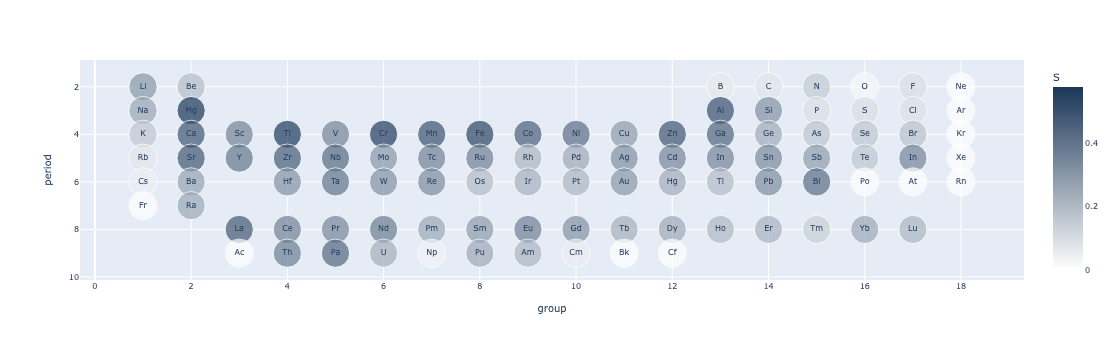

In [105]:
colorscale=create_colorscale((255, 255, 255),(255,0,0),50)
fig = px.scatter(dpt, x="group", y="period", text='element', size=8*np.ones(len(dpt)),size_max=20, opacity=0.7, \
                 color='S',color_continuous_scale=create_colorscale((255,255,255),(27,54,87),5))
# fig = px.scatter(dpt, x="group", y="period", text='element', size=15*np.ones(len(dpt)), opacity=0.5, color='S',color_continuous_scale=colorscale)
# fig = px.scatter(dpt, x="group", y="period", 
	        #  size="S",size_max=23,opacity=0.5)

fig.update_layout(
    yaxis = dict(autorange="reversed")
)

# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/S_elements.png",width=15*300, height=10*300, scale=1)

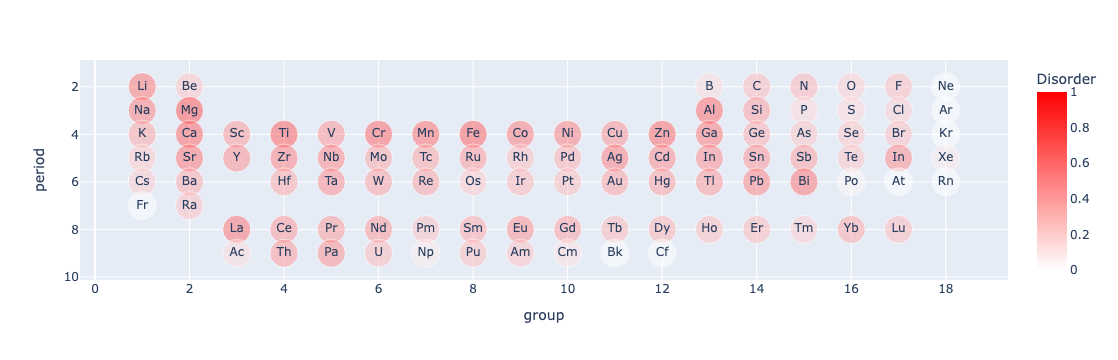

In [106]:
colorscale=create_colorscale((255, 255, 255),(255,0,0),50)
# fig = px.scatter(dpt, x="group", y="period", text='element', size=23*np.ones(len(dpt)), opacity=0.5, color='O',color_continuous_scale=colorscale)
fig = px.scatter(dpt, x="group", y="period", text='element', size=2*np.ones(len(dpt)),size_max=20, opacity=0.5, color='Disorder',color_continuous_scale=colorscale,range_color=(0,1))
# fig = px.scatter(dpt, x="group", y="period", 
# 	         size="S",size_max=23,opacity=0.5)

fig.update_layout(
    yaxis = dict(autorange="reversed")
)
fig.show()

## Distribution of disorder for alkali metals

alkali_me=['Li','Na','K','Rb','Cs']

In [157]:
alkali_me=['Li','Na','K','Rb','Cs']

In [158]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el in alkali_me):
                switch=1
    if(switch==1):
        ind.append(i)

In [159]:
alkali=dbmax_struct.iloc[ind]
len(alkali)

20803

In [160]:
elem_disorder, elem_disorder_frac=calculate_elements(alkali_me,alkali)

In [161]:
def plot_elements_1bar(elem_disorder, filename, frac=True,barWidth=1,figsize=(15,5),xfontsize=9,yfontsize=10): 
    bars, total, names, r, bottom3 = bars_fill(elem_disorder,frac)
    
    if(frac==True):
        caption='fraction of ordered/disordered compounds'
    else:
        caption='number of ordered/disordered compounds'
    
    plt.figure(figsize=figsize)

    # Create brown bars
    plt.bar(r, bars[0,:], color='blue', edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    plt.bar(r, bars[1,:], bottom=bars[0,:], color='orange', edgecolor='white', width=barWidth,label='S')
    plt.bar(r, bars[2,:], bottom=bottom3[0,:], color='red', edgecolor='white', width=barWidth,label='V')
    plt.bar(r, bars[3,:], bottom=bottom3[1,:], color='green', edgecolor='white', width=barWidth,label='SV')
    plt.bar(r, bars[4,:], bottom=bottom3[2,:], color='magenta', edgecolor='white', width=barWidth,label='VP')
    plt.bar(r, bars[5,:], bottom=bottom3[3,:], color='black', edgecolor='white', width=barWidth,label='SVP') 

    # Custom X axis
    plt.xticks(r, names, fontweight='bold',fontsize=xfontsize)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    plt.ylabel(caption,fontweight='bold',fontsize=yfontsize)
    plt.ylim(0,1)
    plt.legend()
    path='/Users/elenapatyukova/Documents/Disorder-prediction/figures/'
    plt.savefig(path+filename, transparent=None, dpi=400, format='png')

    # Show graphic
    plt.show()

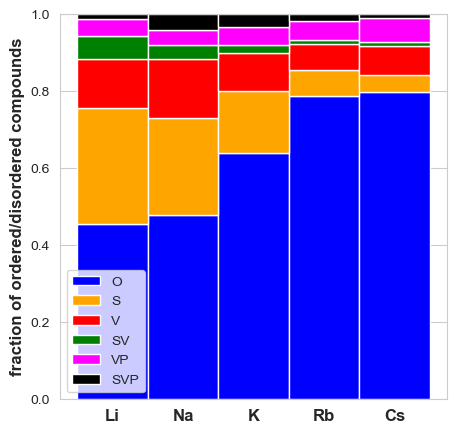

In [162]:
plot_elements_1bar(elem_disorder_frac, filename='alkali.png', frac=True,barWidth=1,figsize=(5,5),xfontsize=12,yfontsize=12)

## Distribution of disorder for Alkaline Earth Metals

In [163]:
alkaline_earth_me=['Be','Mg','Ca','Sr','Ba']

In [164]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el in alkaline_earth_me):
                switch=1
    if(switch==1):
        ind.append(i)

In [165]:
alkaline=dbmax_struct.iloc[ind]
len(alkaline)

26782

In [166]:
elem_disorder, elem_disorder_frac=calculate_elements(alkaline_earth_me,alkaline)

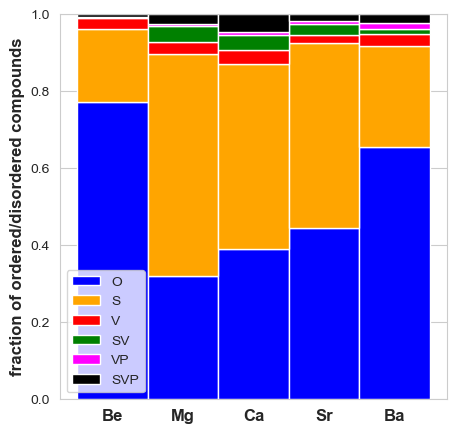

In [167]:
plot_elements_1bar(elem_disorder_frac, filename='alkaline_earth.png', frac=True,barWidth=1,figsize=(5,5),xfontsize=12,yfontsize=12)

# Distribution over structures

### Distribution over space groups

In [192]:
dbmax_struct.columns

Index(['formula', 'ICSD_ID', 'group_num', 'Z', 'label', 'species',
       'multiplicity', 'Wyckoff_symbol', 'occupancy', 'internal_intersection',
       'external_intersection', 'intersecting_orbits',
       'intersect_orbit_connected', 'orbit_disorder', 'entropy', 'Unnamed: 0',
       'DB_id', 'Col_code', 'name', 'StructureType', 'Temperature', 'Pressure',
       'CellVolume', 'FormulaUnitsPerCell', 'MineralName', 'MineralGroup',
       'PearsonSymbol', 'ANXFormula', 'ABFormula', 'disorder_set', 'num_el',
       'num_orb', 'ordered_formula', 'normalised_composition',
       'orbit_elements_comp'],
      dtype='object')

In [193]:
element_disorder=dbmax_struct[['ICSD_ID','formula','disorder_set','orbit_disorder','orbit_elements_comp','group_num']]

In [194]:
mapping_groups_sys={}
mapping_groups_sys['triclinic']=[1,2]
mapping_groups_sys['monoclinic']=list(np.linspace(3,15,13,dtype=int))
mapping_groups_sys['orthorhombic']=list(np.linspace(16,74,59,dtype=int))
mapping_groups_sys['tetragonal']=list(np.linspace(75,142,68,dtype=int))
mapping_groups_sys['trigonal']=list(np.linspace(143,167,25,dtype=int))
mapping_groups_sys['hexagonal']=list(np.linspace(168,194,27,dtype=int))
mapping_groups_sys['cubic']=list(np.linspace(195,230,36,dtype=int))

mapping_groups={}
mapping_groups['1']=[1]
mapping_groups['-1']=[2]
mapping_groups['2']=[3,4,5]
mapping_groups['m']=[6,7,8,9]
mapping_groups['2/m']=[10,11,12,13,14,15]
mapping_groups['222']=[16,17,18,19,20,21,22,23,24]
mapping_groups['mm2']=[25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46]
mapping_groups['2/m 2/m 2/m']=list(np.linspace(47,74,28,dtype=int))
mapping_groups['4']=list(np.linspace(75,80,6,dtype=int))
mapping_groups['-4']=list(np.linspace(81,82,2,dtype=int))
mapping_groups['4/m']=list(np.linspace(83,88,6,dtype=int))
mapping_groups['422']=list(np.linspace(89,98,10,dtype=int))
mapping_groups['4mm']=list(np.linspace(99,110,12,dtype=int))
mapping_groups['-42m']=list(np.linspace(111,122,12,dtype=int))
mapping_groups['4/m 2/m 2/m']=list(np.linspace(123,142,20,dtype=int))
mapping_groups['3']=list(np.linspace(143,146,4,dtype=int))
mapping_groups['-3']=list(np.linspace(147,148,2,dtype=int))
mapping_groups['32']=list(np.linspace(149,155,7,dtype=int))
mapping_groups['3m']=list(np.linspace(156,161,6,dtype=int))
mapping_groups['3 2/m']=list(np.linspace(162,167,6,dtype=int))
mapping_groups['6']=list(np.linspace(168,173,6,dtype=int))
mapping_groups['-6']=[174]
mapping_groups['6/m']=[175,176]
mapping_groups['622']=list(np.linspace(177,182,6,dtype=int))
mapping_groups['6mm']=list(np.linspace(183,186,4,dtype=int))
mapping_groups['-6m2']=list(np.linspace(187,190,4,dtype=int))
mapping_groups['6/m 2/m 2/m']=list(np.linspace(191,194,4,dtype=int))
mapping_groups['23']=list(np.linspace(195,199,5,dtype=int))
mapping_groups['2/m -3']=list(np.linspace(200,206,7,dtype=int))
mapping_groups['432']=list(np.linspace(207,214,8,dtype=int))
mapping_groups['-43m']=list(np.linspace(215,220,6,dtype=int))
mapping_groups['4/m -3 2/m']=list(np.linspace(221,230,10,dtype=int))

In [195]:
crystal_sys=[]
for i in range(len(element_disorder)):
    num=element_disorder.iloc[i]['group_num']
    for key,value in mapping_groups_sys.items():
        if(num in value):
            crystal_sys.append(key)

point_groups=[]
for i in range(len(element_disorder)):
    num=element_disorder.iloc[i]['group_num']
    for key,value in mapping_groups.items():
        if(num in value):
            point_groups.append(key)

olist=[{'O'}]
slist=[{'S'},{'O','S'}]
vlist=[{'V'},{'O','V'},{'VP'},{'VP','O'},{'V','VP'},{'O','V','VP'}]
            
dis_class=[]
for i in range(len(element_disorder)):
    dis=element_disorder.iloc[i]['disorder_set']
    if(dis in olist):
        dis_class.append('O')
    elif(dis in slist):
        dis_class.append('S')
    elif(dis in vlist):
        dis_class.append('V')
    else:
        dis_class.append('M')

element_disorder['crystal_system']=crystal_sys
element_disorder['point_groups']=point_groups
element_disorder['disorder_class']=dis_class

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/3510441209.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/3510441209.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/3510441209.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [196]:
space_groups=np.linspace(1,230,230,dtype=int)

In [197]:
def calculate_for_space_groups(element_disorder,space_groups):
    group_disorder={}
    for key in space_groups:
        group_disorder[key]=np.zeros(4)

    for i in range(len(element_disorder)):
        dis_class=element_disorder['disorder_class'].values[i]
        group=element_disorder['group_num'].values[i]
        
        if(dis_class=='O'):
            group_disorder[group][0]+=1
        elif(dis_class=='S'):
            group_disorder[group][1]+=1
        elif(dis_class=='V'):
            group_disorder[group][2]+=1
        elif(dis_class=='M'):
            group_disorder[group][3]+=1

    group_disorder_frac={}
    total_values=[]
    frac_values=[]
    for key in group_disorder.keys():
        group_disorder_frac[key]=np.zeros(5)
        group_disorder_frac[key][0]=np.sum(group_disorder[key])
        total_values.append(group_disorder_frac[key][0])
        if(group_disorder_frac[key][0]!=0):
            for i in range(1,5):
                group_disorder_frac[key][i]=round(group_disorder[key][i-1]/group_disorder_frac[key][0],2)
        else:
            for i in range(1,5):
                group_disorder_frac[key][i]=0
        frac_values.append(group_disorder_frac[key][1:7])

    return group_disorder, group_disorder_frac

In [199]:
group_disorder, group_disorder_frac=calculate_for_space_groups(element_disorder,space_groups)

In [175]:
def plot_groups(group_disorder_frac, title, filename, frac=True,barWidth=1,names=None,x_caption=None,figsize=(15,7)): 
    bars, total, names_simple, r, bottom3 = bars_fill(group_disorder_frac,frac)
    
    if(frac==True):
        caption='fraction of ordered/disordered compounds'
    else:
        caption='number of ordered/disordered compounds'
    
    plt.figure(figsize=figsize)
    ax1=plt.subplot(111)
    ax2=ax1.twiny()
    # Create brown bars

    ax1.bar(names_simple, bars[0,:], color='blue', edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(names_simple, bars[1,:], bottom=bars[0,:], color='orange', edgecolor='white', width=barWidth,label='S')
    ax1.bar(names_simple, bars[2,:], bottom=bottom3[0,:], color='red', edgecolor='white', width=barWidth,label='V')
    ax1.bar(names_simple, bars[3,:], bottom=bottom3[1,:], color='green', edgecolor='white', width=barWidth,label='P')
    ax1.bar(names_simple, bars[4,:], bottom=bottom3[2,:], color='magenta', edgecolor='white', width=barWidth,label='SV')
    ax1.bar(names_simple, bars[5,:], bottom=bottom3[3,:], color='cyan', edgecolor='white', width=barWidth,label='SP') 
    ax1.bar(names_simple, bars[6,:], bottom=bottom3[4,:], color='purple', edgecolor='white', width=barWidth,label='VP')
    ax1.bar(names_simple, bars[7,:], bottom=bottom3[5,:], color='black', edgecolor='white', width=barWidth,label='SVP')

    # Custom X axis
    if(names!=None):
        ax1.set_xticks(range(len(names)), names, rotation='vertical',fontsize=9,fontweight='bold')
    if(x_caption!=None):
        ax1.set_xlabel(x_caption,fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=12)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(names_simple)
    ax2.set_xticklabels(total,rotation='vertical')
    ax1.legend()
    ax1.set_title(title,fontweight='bold',fontsize=12)
    path='/Users/elenapatyukova/Documents/Disorder-prediction/figures/'
    plt.savefig(path+filename, transparent=None, dpi=400, format='png',bbox_inches='tight')
    plt.grid(visible=False)
    
    plt.show()

In [200]:
df=pd.DataFrame.from_dict(group_disorder_frac,orient='index',columns=['total','O','S','V','M'])

In [201]:
df.reset_index(drop=True,inplace=True)
df['space_group']=np.linspace(1,230,230,dtype=int)


In [202]:
nm={}
for x,key in enumerate(mapping_groups_sys.keys()):
    nm[key]=x

nm1={}
for x,key in enumerate(mapping_groups.keys()):
    nm1[key]=x

In [203]:
crystal_system=[]
point_groups=[]
for num in space_groups:
    for key, value in mapping_groups_sys.items():
        if(num in value):
            crystal_system.append(key)
    for key, value in mapping_groups.items():
        if(num in value):
            point_groups.append(key)

In [204]:
df['D']=np.ones(len(df))-df['O'].values

In [205]:
df['crystal_system']=crystal_system
df['crystal_class']=point_groups

In [206]:
df['weights']=df['total'].values+np.ones(len(df))*0.01

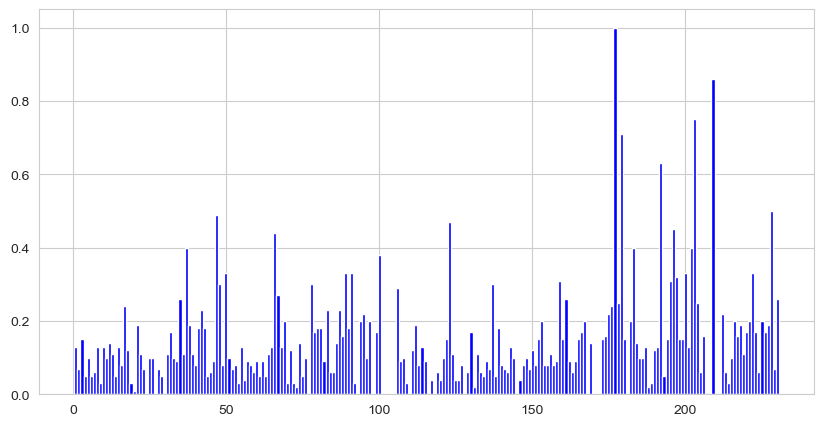

In [212]:
plt.figure(figsize=(10,5))
plt.bar(df['space_group'].values,df['M'].values,color='blue', edgecolor='white', width=1,label='O')
plt.show()

In [213]:

df

total     O     S     V     M  space_group     D crystal_system  \
0     229.0  0.64  0.18  0.05  0.13            1  0.36      triclinic   
1    2295.0  0.68  0.16  0.08  0.07            2  0.32      triclinic   
2      26.0  0.50  0.27  0.08  0.15            3  0.50     monoclinic   
3     426.0  0.77  0.12  0.06  0.05            4  0.23     monoclinic   
4     261.0  0.60  0.21  0.10  0.10            5  0.40     monoclinic   
..      ...   ...   ...   ...   ...          ...   ...            ...   
225   218.0  0.23  0.44  0.16  0.17          226  0.77          cubic   
226  5613.0  0.13  0.62  0.06  0.19          227  0.87          cubic   
227     4.0  0.25  0.25  0.00  0.50          228  0.75          cubic   
228   755.0  0.22  0.65  0.07  0.07          229  0.78          cubic   
229   710.0  0.14  0.55  0.05  0.26          230  0.86          cubic   

    crystal_class  weights  
0               1   229.01  
1              -1  2295.01  
2               2    26.01  
3               2   426.01  
4               2   261.01  
..            ...      ...  
225    4/m -3 2/m   218.01  
226    4/m -3 2/m  5613.01  
227    4/m -3 2/m     4.01  
228    4/m -3 2/m   755.01  
229    4/m -3 2/m   710.01  

[230 rows x 10 columns]

In [214]:
df1=df.copy()

In [216]:
new_s=[]

for s in df['S'].values:
    if(s<np.mean(df['S'])+2*np.std(df['S'])):
        new_s.append(s)
    else:
        new_s.append(np.mean(df['S'])+2*np.std(df['S']))
        
new_v=[]

for s in df['V'].values:
    if(s<np.mean(df['V'])+2*np.std(df['V'])):
        new_v.append(s)
    else:
        new_v.append(np.mean(df['V'])+2*np.std(df['V']))
        
new_m=[]

for s in df['M'].values:
    if(s<np.mean(df['M'])+2*np.std(df['M'])):
        new_m.append(s)
    else:
        new_m.append(np.mean(df['M'])+2*np.std(df['M']))

In [217]:
df1['S']=new_s
df1['V']=new_v
df1['M']=new_m

In [218]:
df1

total     O         S     V         M  space_group     D crystal_system  \
0     229.0  0.64  0.180000  0.05  0.130000            1  0.36      triclinic   
1    2295.0  0.68  0.160000  0.08  0.070000            2  0.32      triclinic   
2      26.0  0.50  0.270000  0.08  0.150000            3  0.50     monoclinic   
3     426.0  0.77  0.120000  0.06  0.050000            4  0.23     monoclinic   
4     261.0  0.60  0.210000  0.10  0.100000            5  0.40     monoclinic   
..      ...   ...       ...   ...       ...          ...   ...            ...   
225   218.0  0.23  0.440000  0.16  0.170000          226  0.77          cubic   
226  5613.0  0.13  0.576227  0.06  0.190000          227  0.87          cubic   
227     4.0  0.25  0.250000  0.00  0.424658          228  0.75          cubic   
228   755.0  0.22  0.576227  0.07  0.070000          229  0.78          cubic   
229   710.0  0.14  0.550000  0.05  0.260000          230  0.86          cubic   

    crystal_class  weights  
0               1   229.01  
1              -1  2295.01  
2               2    26.01  
3               2   426.01  
4               2   261.01  
..            ...      ...  
225    4/m -3 2/m   218.01  
226    4/m -3 2/m  5613.01  
227    4/m -3 2/m     4.01  
228    4/m -3 2/m   755.01  
229    4/m -3 2/m   710.01  

[230 rows x 10 columns]

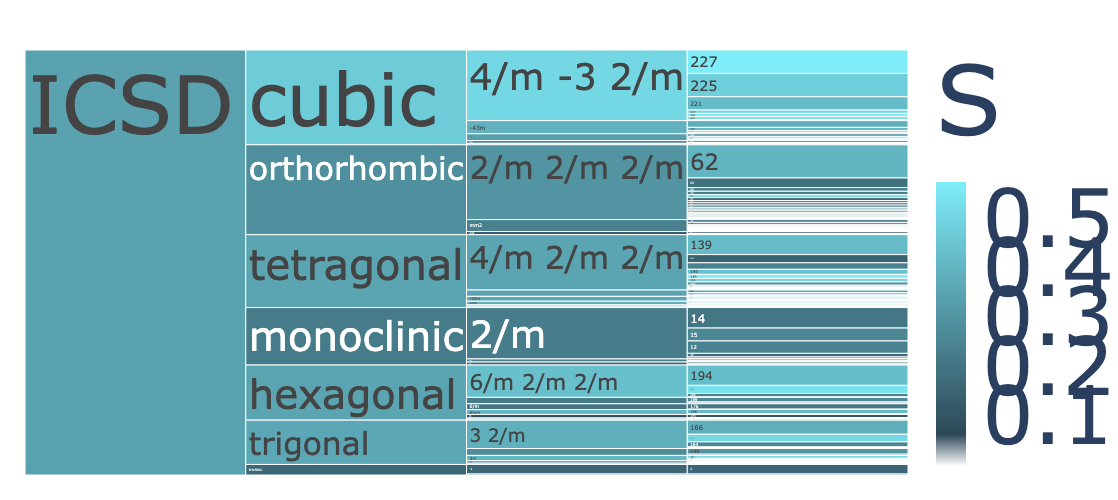

In [219]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='S',
                  color_continuous_scale=create_colorscale((34,51, 67),(127, 237, 249),10),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()

fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/S_structures.png",width=5*300, height=8*300, scale=1)
# 'RdBu'

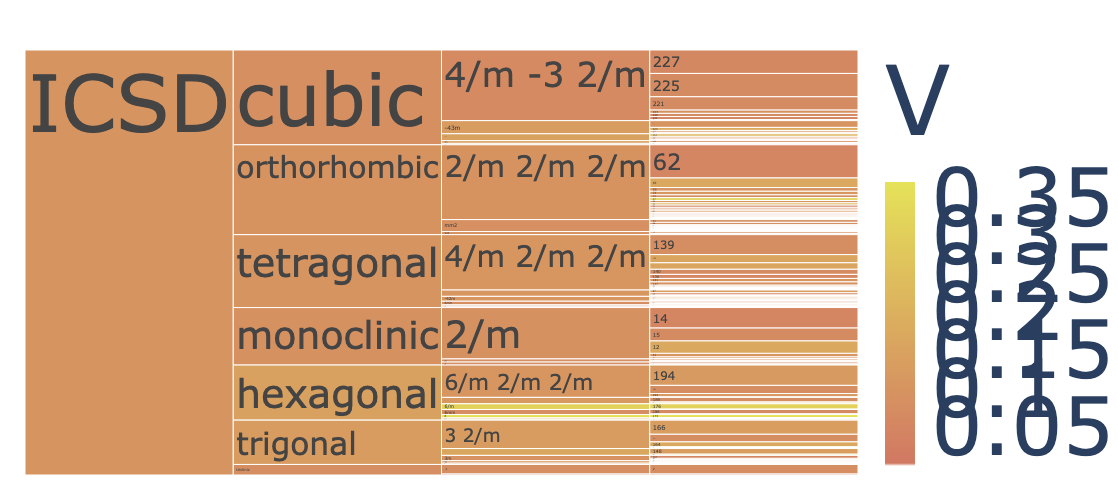

In [220]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='V',
                  color_continuous_scale=create_colorscale((209, 119, 99),(229, 226, 89),100),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()

fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/V_structures.png",width=5*300, height=8*300, scale=1)
# 'RdBu'

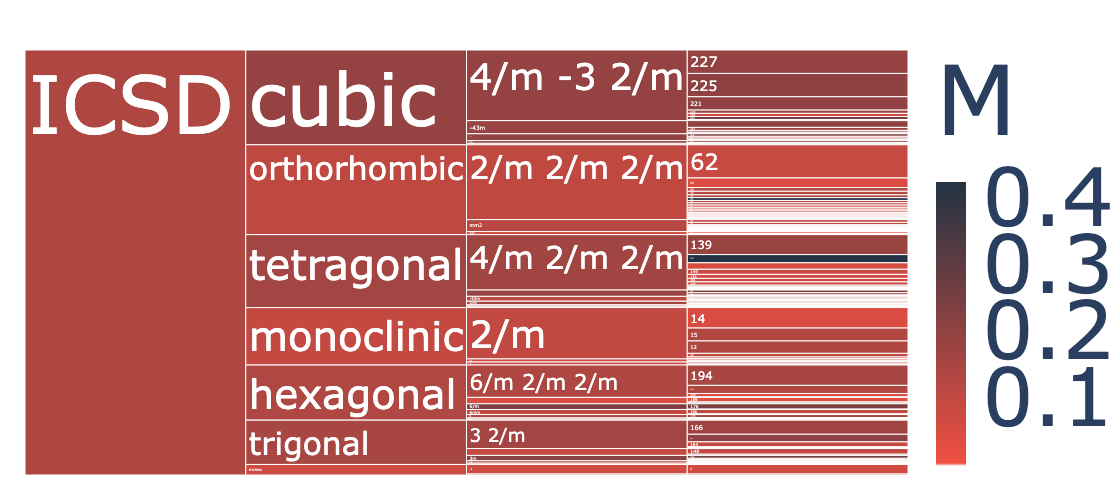

In [222]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='M',
                  color_continuous_scale=create_colorscale((242, 80, 65),(34,51,67),100),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/M_structures.png",width=5*300, height=8*300, scale=1)

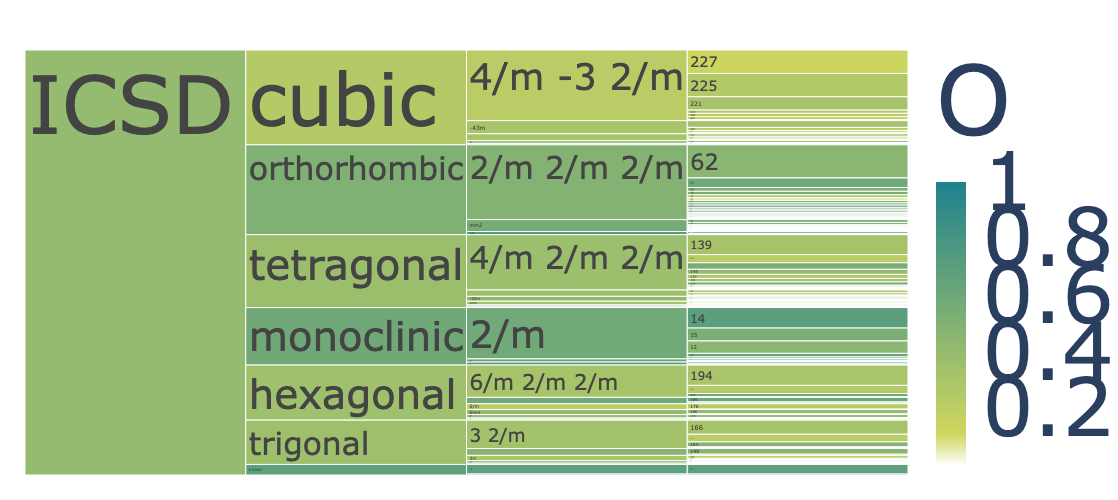

In [355]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='O',
                  color_continuous_scale=create_colorscale((229, 226, 89),(31, 129, 142),10),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()

fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=80))
fig.show()
fig.write_image("images/O_structures.png",width=5*300, height=8*300, scale=1)

# Oxides

35120


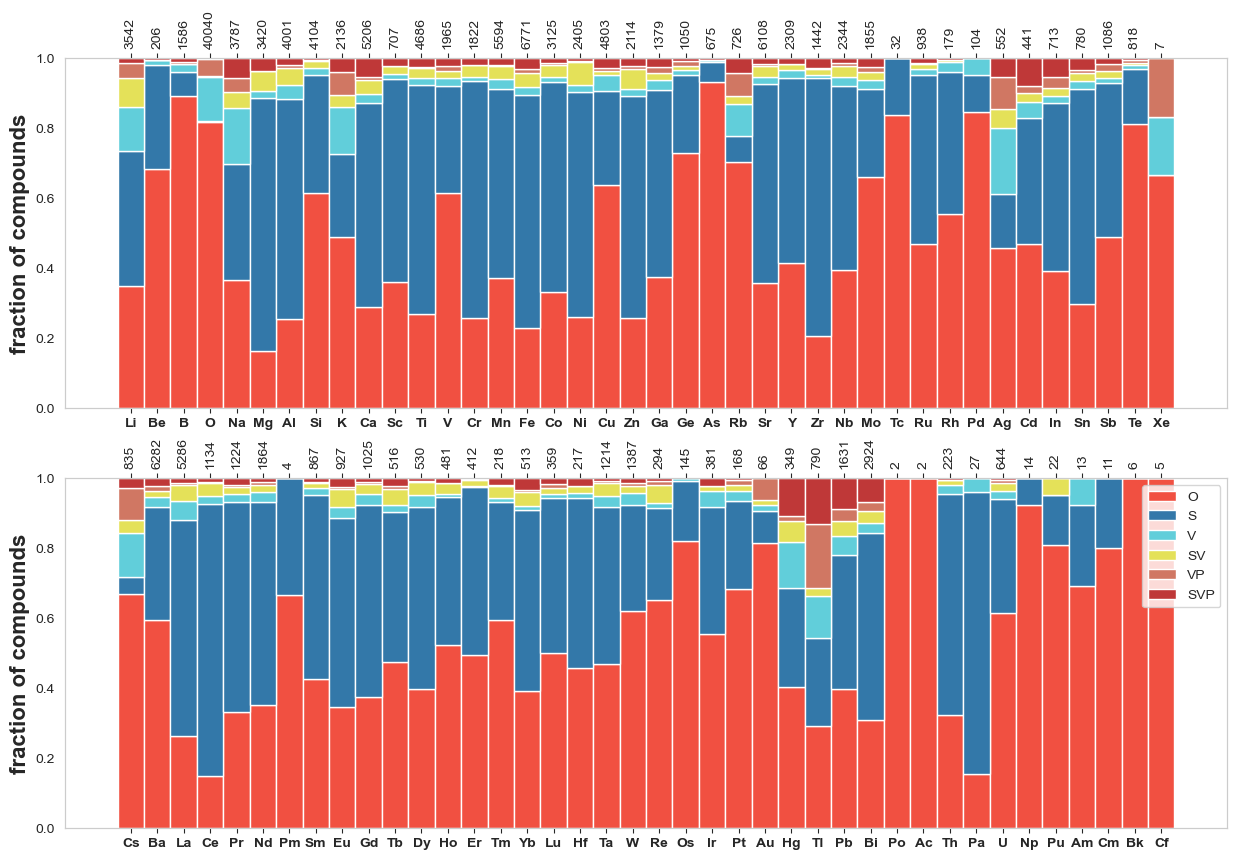

In [399]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='O'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='F'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
print(len(oxides))

elem_oxides=['Li', 'Be', 'B', 'O', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/oxides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Fluorides

2093


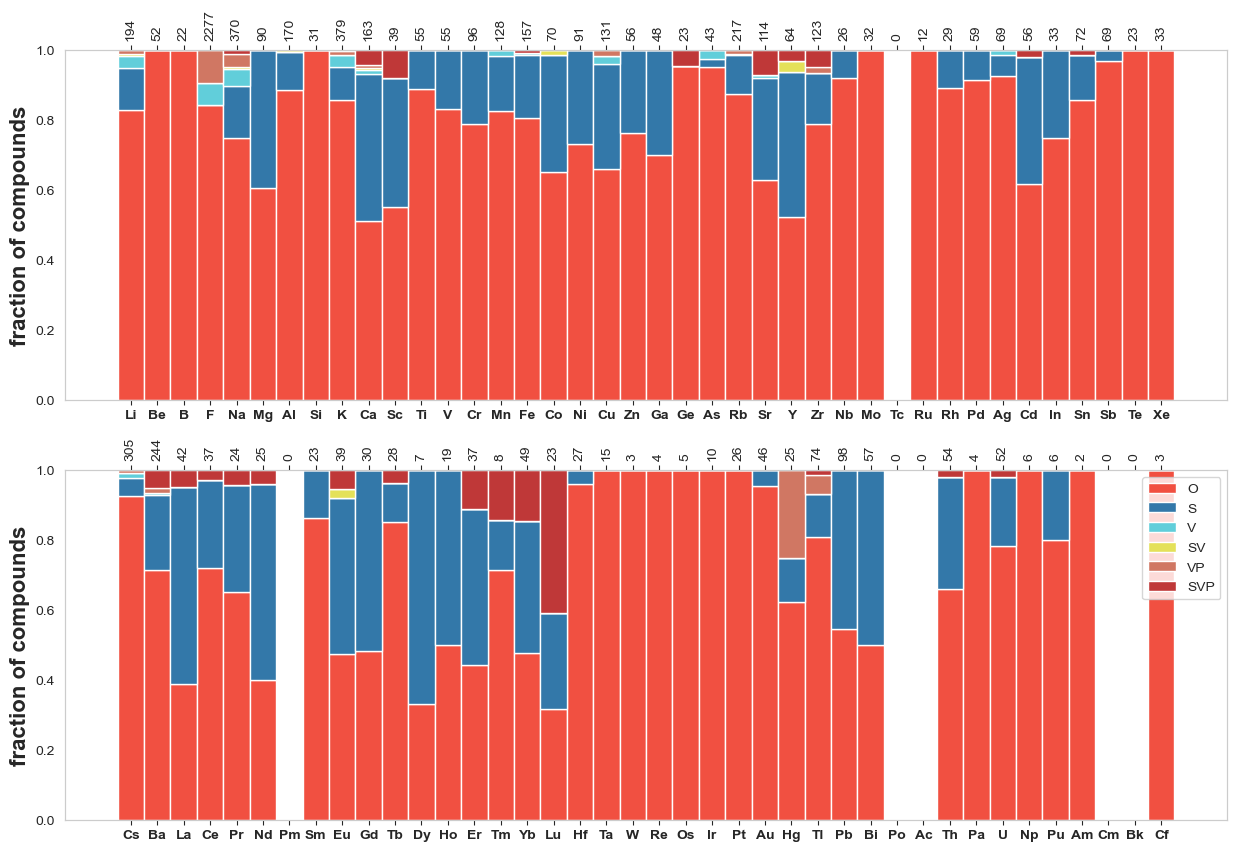

In [412]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='F'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

fluorides=dbmax_struct.iloc[ind]
fluorides.reset_index(inplace=True, drop=True)
print(len(fluorides))

elem_fluorides=['Li', 'Be', 'B', 'F', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_fluorides,fluorides)

plot_elements(elem_disorder_frac, filename='images/fluorides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Sulfides

5725


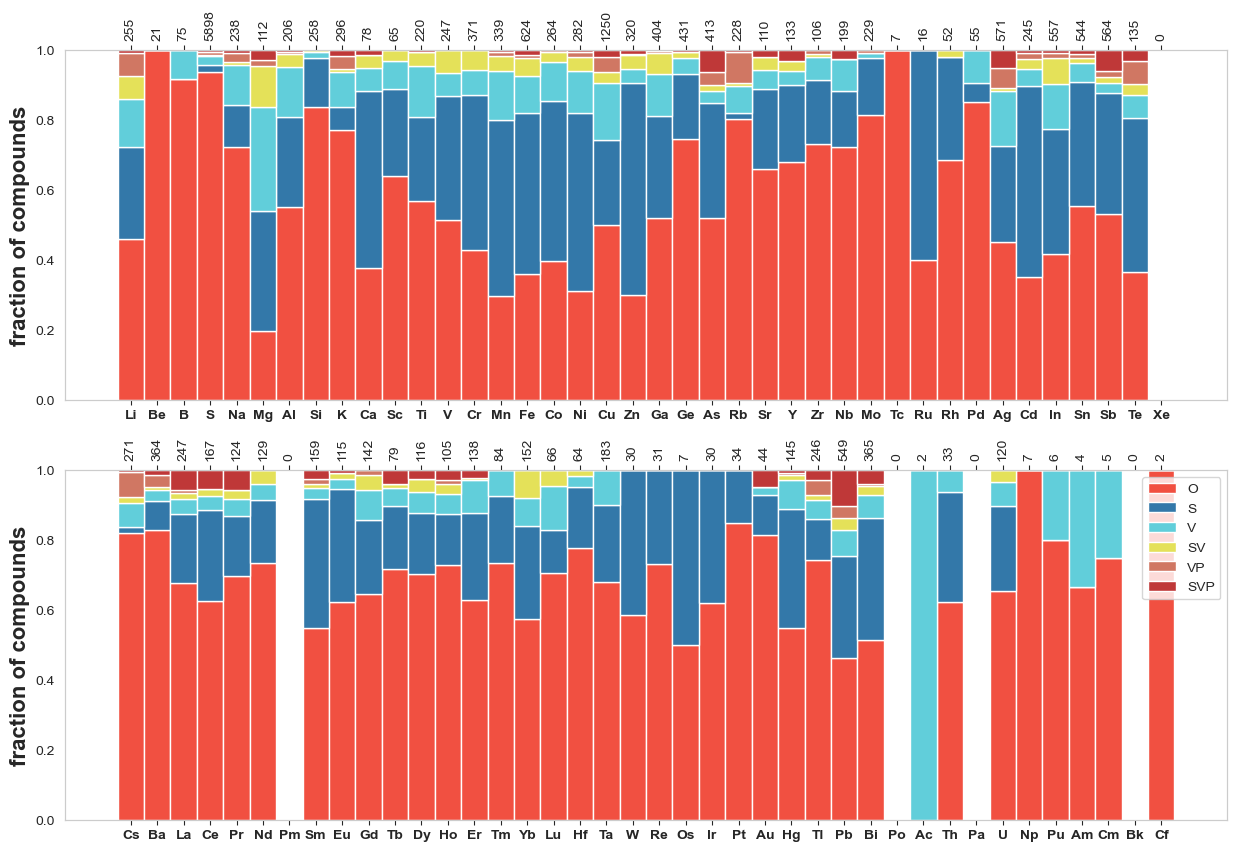

In [413]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='S'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='F'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

sulfides=dbmax_struct.iloc[ind]
sulfides.reset_index(inplace=True, drop=True)
print(len(sulfides))

elem_sulfides=['Li', 'Be', 'B', 'S', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_sulfides,sulfides)

plot_elements(elem_disorder_frac, filename='images/sulfides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

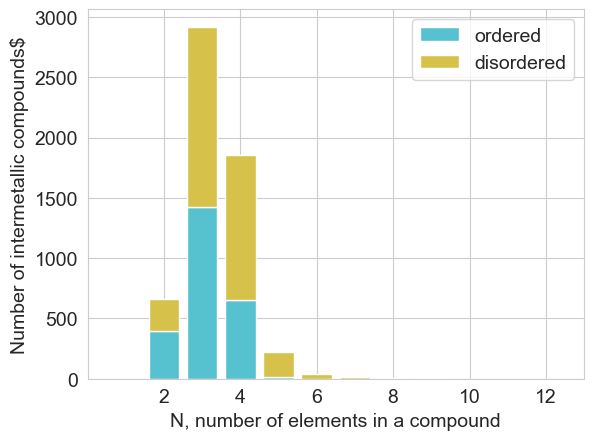

In [379]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=sulfides.loc[sulfides['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o))
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d))
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)

plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of intermetallic compounds$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
# plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

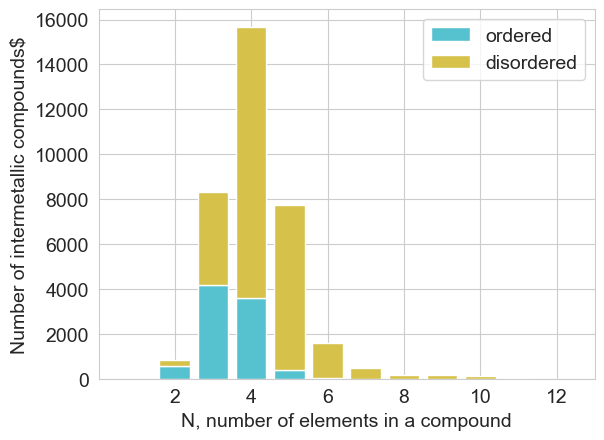

In [402]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=oxides.loc[oxides['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o))
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d))
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)

plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of intermetallic compounds$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
# plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

# Iodides

658


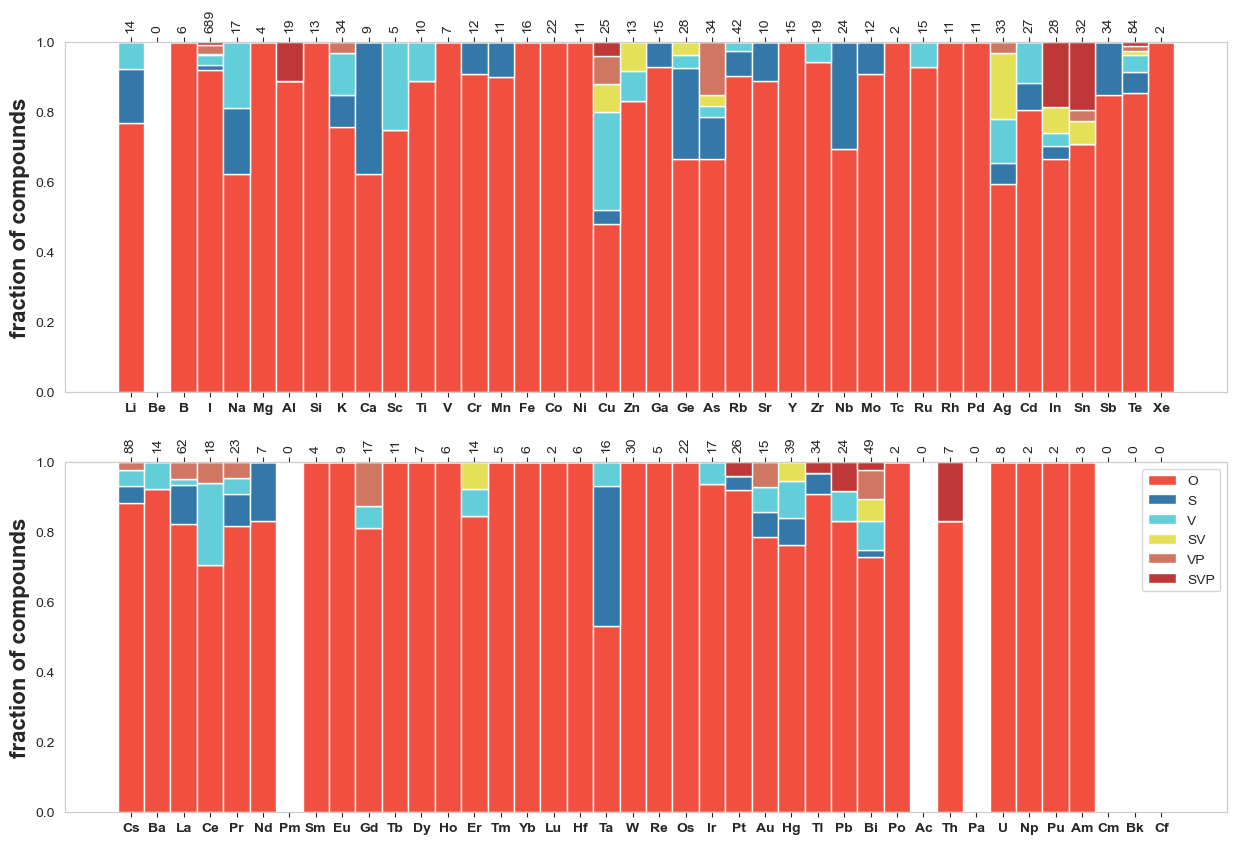

In [414]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='I'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

iodides=dbmax_struct.iloc[ind]
iodides.reset_index(inplace=True, drop=True)
print(len(iodides))

elem_iodides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_iodides,iodides)

plot_elements(elem_disorder_frac, filename='images/iodides.png',n=40,frac=True,barWidth=1)



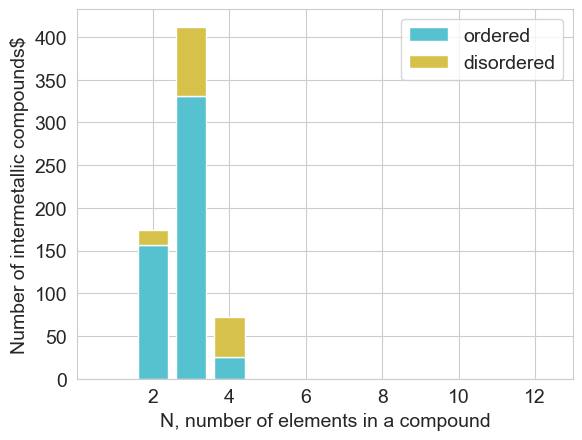

In [415]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=iodides.loc[iodides['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o))
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d))
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)

plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of intermetallic compounds$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
# plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

# Carbides

1947


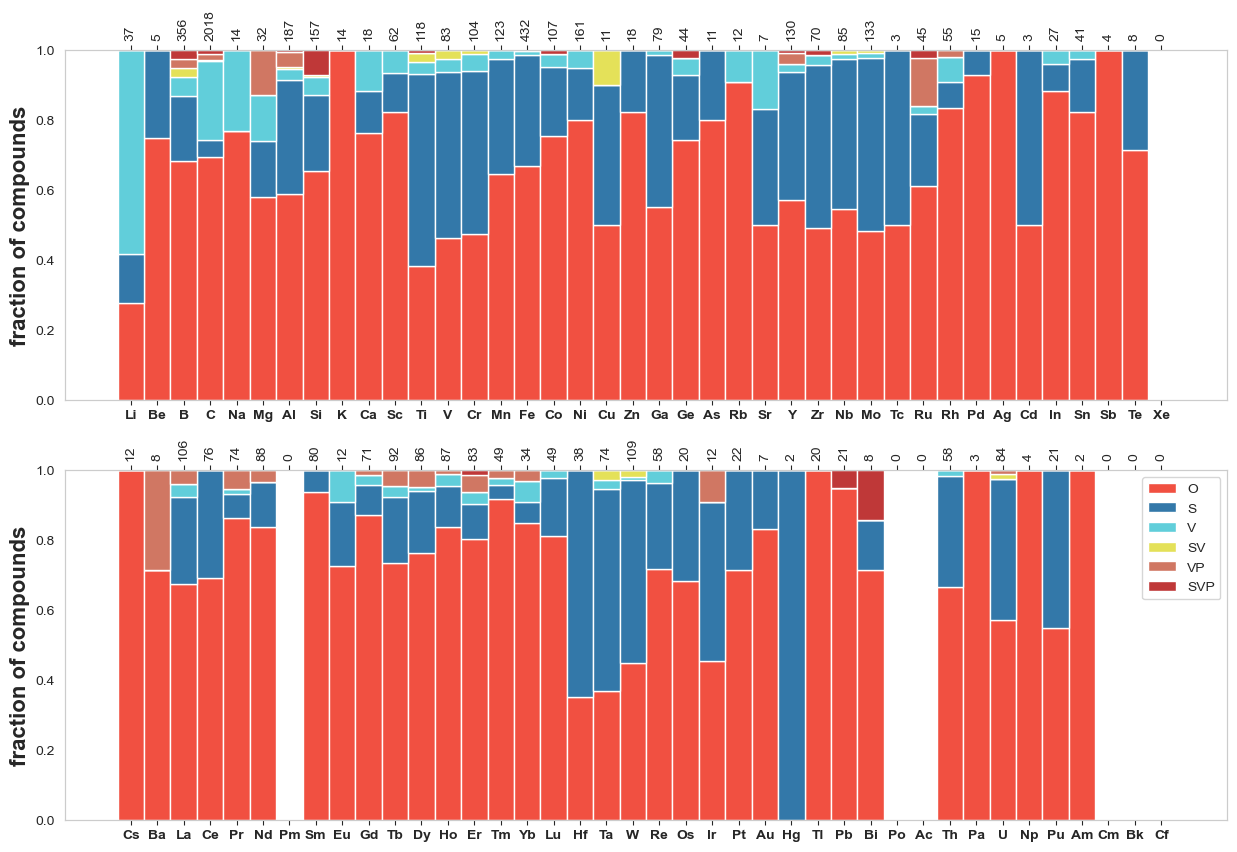

In [416]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='C'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

carbides=dbmax_struct.iloc[ind]
carbides.reset_index(inplace=True, drop=True)
print(len(carbides))

elem_carbides=['Li', 'Be', 'B', 'C', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_carbides,carbides)

plot_elements(elem_disorder_frac, filename='images/carbides.png',n=40,frac=True,barWidth=1)


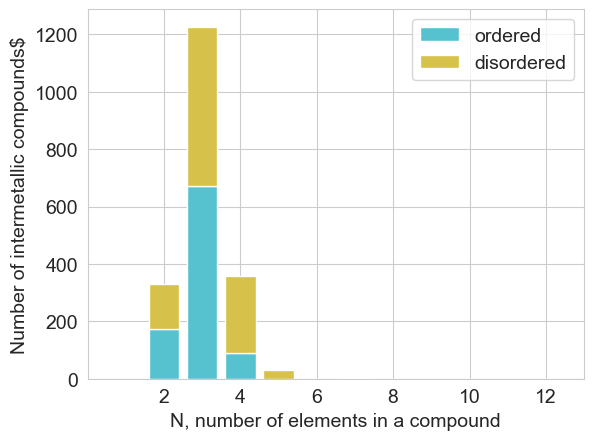

In [382]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=carbides.loc[carbides['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o))
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d))
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)

plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of intermetallic compounds$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
# plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

# Nitrides

1482


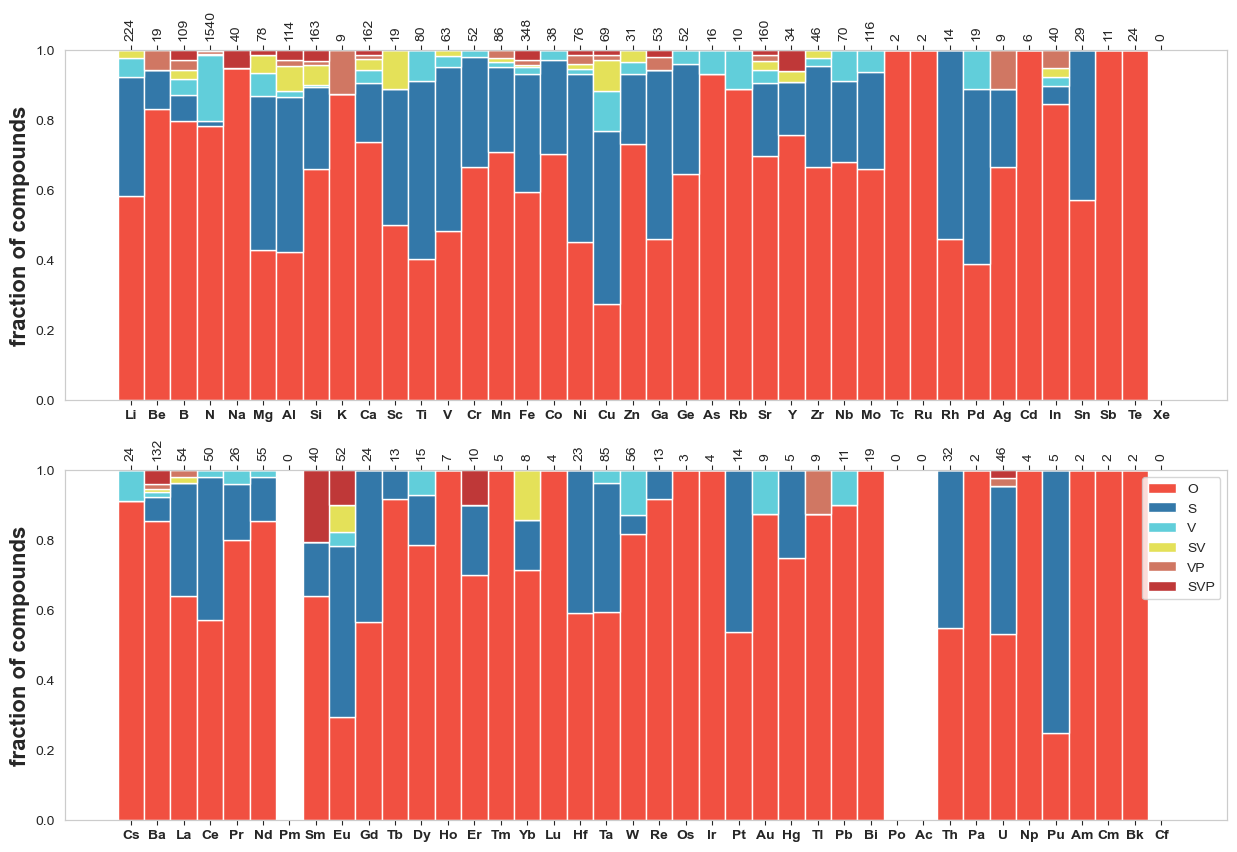

In [417]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='N'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='C'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

nitrides=dbmax_struct.iloc[ind]
nitrides.reset_index(inplace=True, drop=True)
print(len(nitrides))

elem_nitrides=['Li', 'Be', 'B', 'N', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_nitrides,nitrides)

plot_elements(elem_disorder_frac, filename='images/nitrides.png',n=40,frac=True,barWidth=1)

# Phosphides

1891


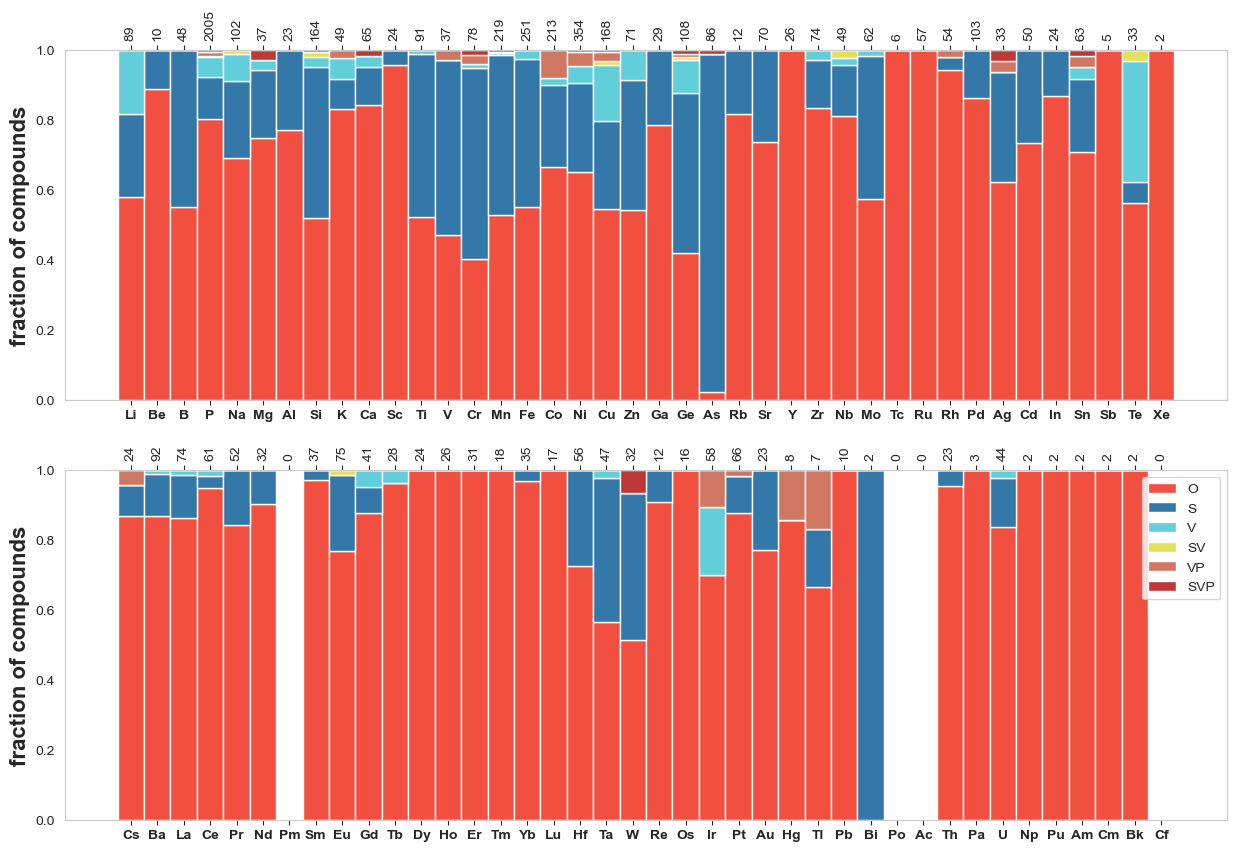

In [418]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='P'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='C'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

phosphides=dbmax_struct.iloc[ind]
phosphides.reset_index(inplace=True, drop=True)
print(len(phosphides))

elem_phosphides=['Li', 'Be', 'B', 'P', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_phosphides,phosphides)

plot_elements(elem_disorder_frac, filename='images/phosphides.png',n=40,frac=True,barWidth=1)

# Chlorides

1123


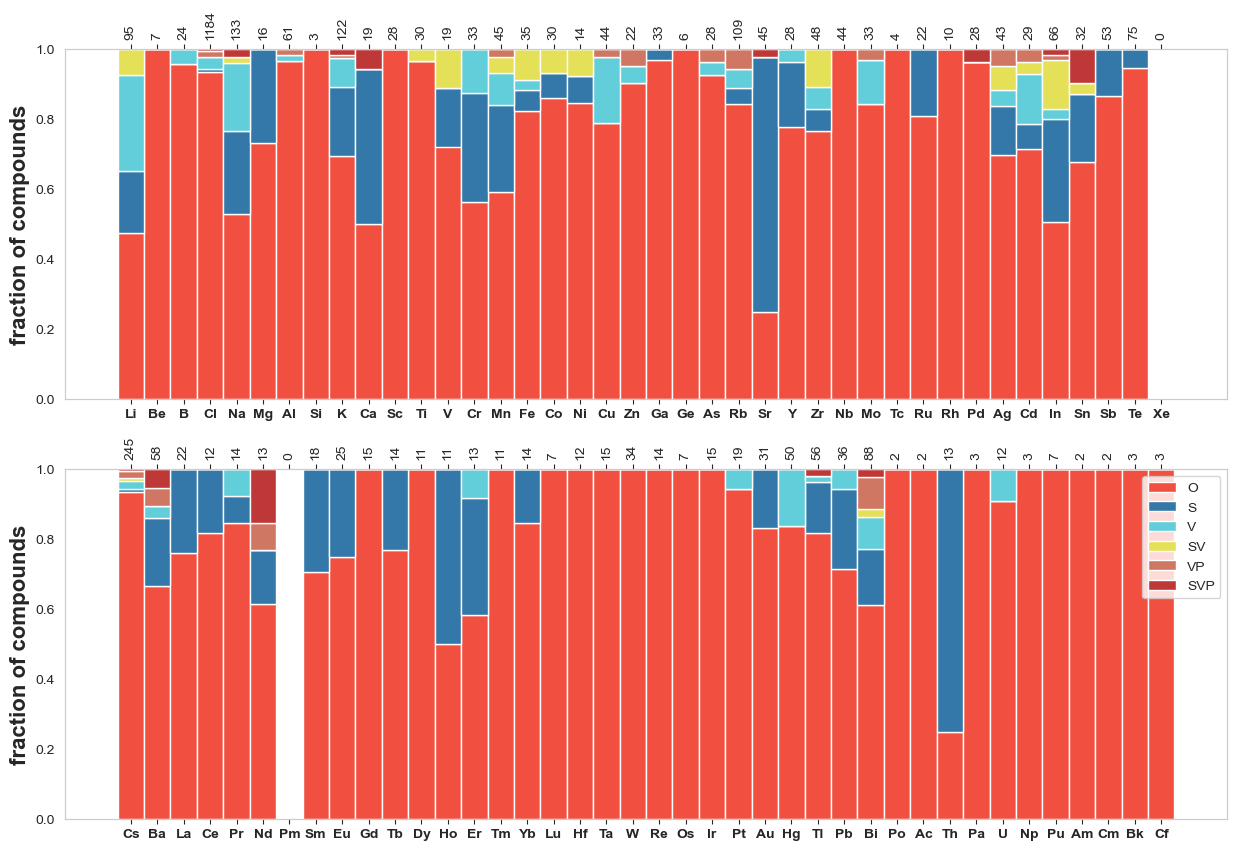

In [419]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Cl'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='C'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

clorides=dbmax_struct.iloc[ind]
clorides.reset_index(inplace=True, drop=True)
print(len(clorides))

elem_clorides=['Li', 'Be', 'B', 'Cl', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_clorides,clorides)

plot_elements(elem_disorder_frac, filename='images/chlorides.png',n=40,frac=True,barWidth=1)

# Selenides

3792


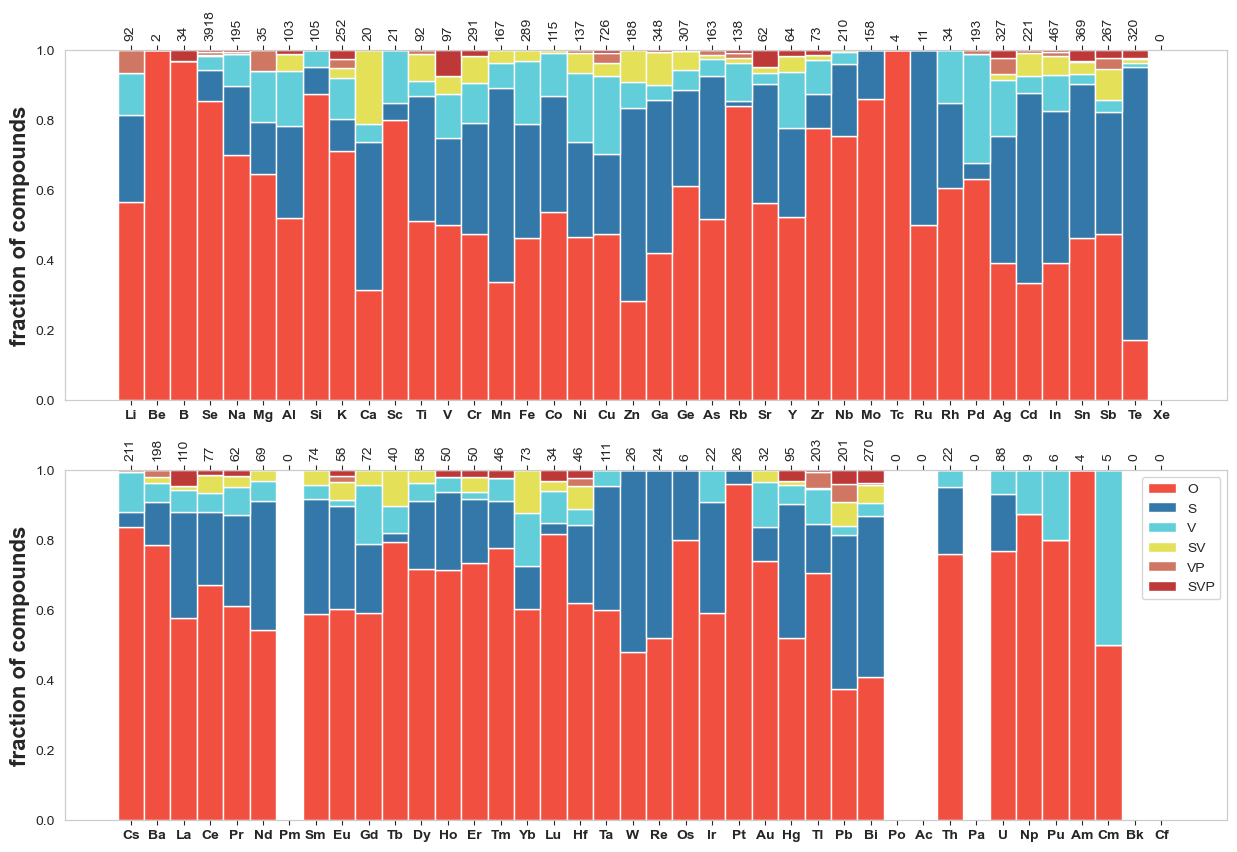

In [420]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Se'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='C' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

selenides=dbmax_struct.iloc[ind]
selenides.reset_index(inplace=True, drop=True)
print(len(selenides))

elem_selenides=['Li', 'Be', 'B', 'Se', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_selenides,selenides)

plot_elements(elem_disorder_frac, filename='images/selenides.png',n=40,frac=True,barWidth=1)

# Bromides

647


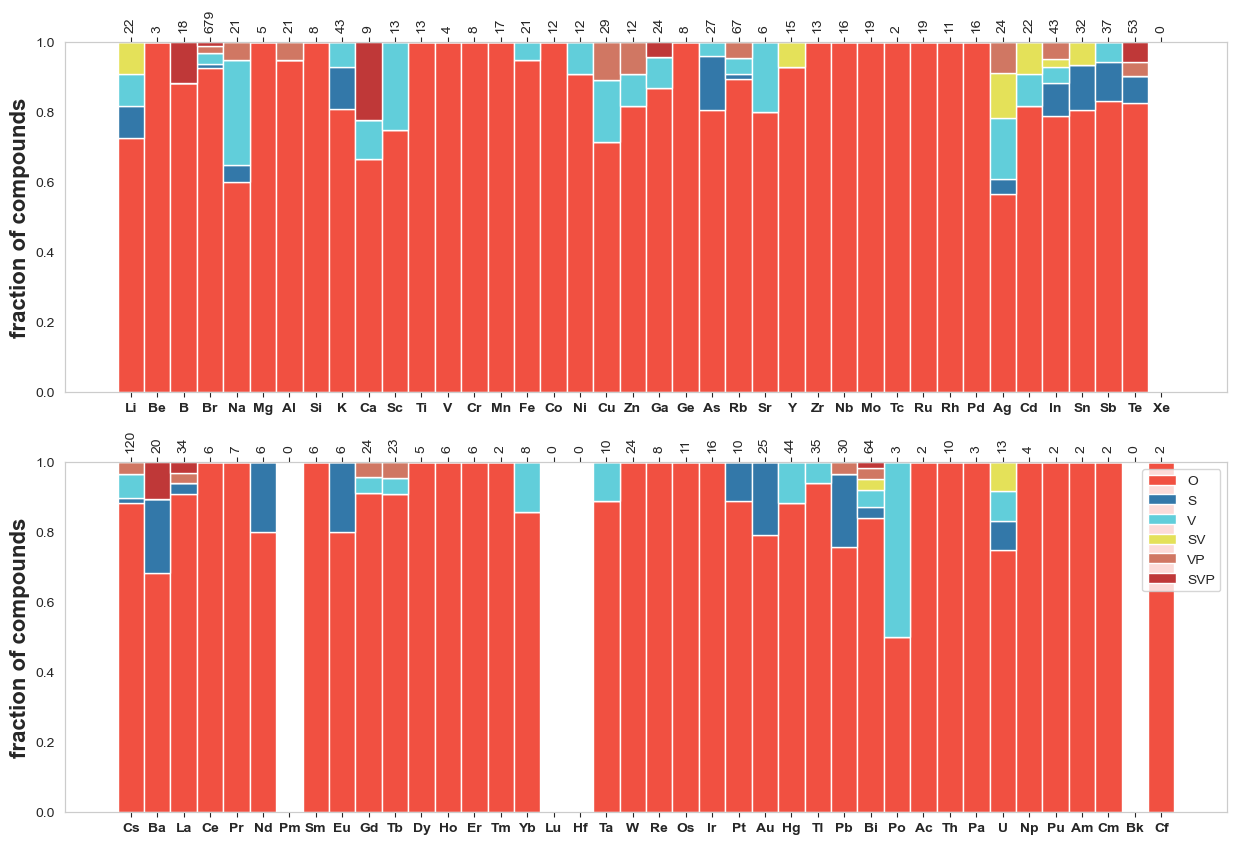

In [421]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Br'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='C'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

bromides=dbmax_struct.iloc[ind]
bromides.reset_index(inplace=True, drop=True)
print(len(bromides))

elem_bromides=['Li', 'Be', 'B', 'Br', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_bromides,bromides)

plot_elements(elem_disorder_frac, filename='images/bromides.png',n=40,frac=True,barWidth=1)

# Intermetallics

17809


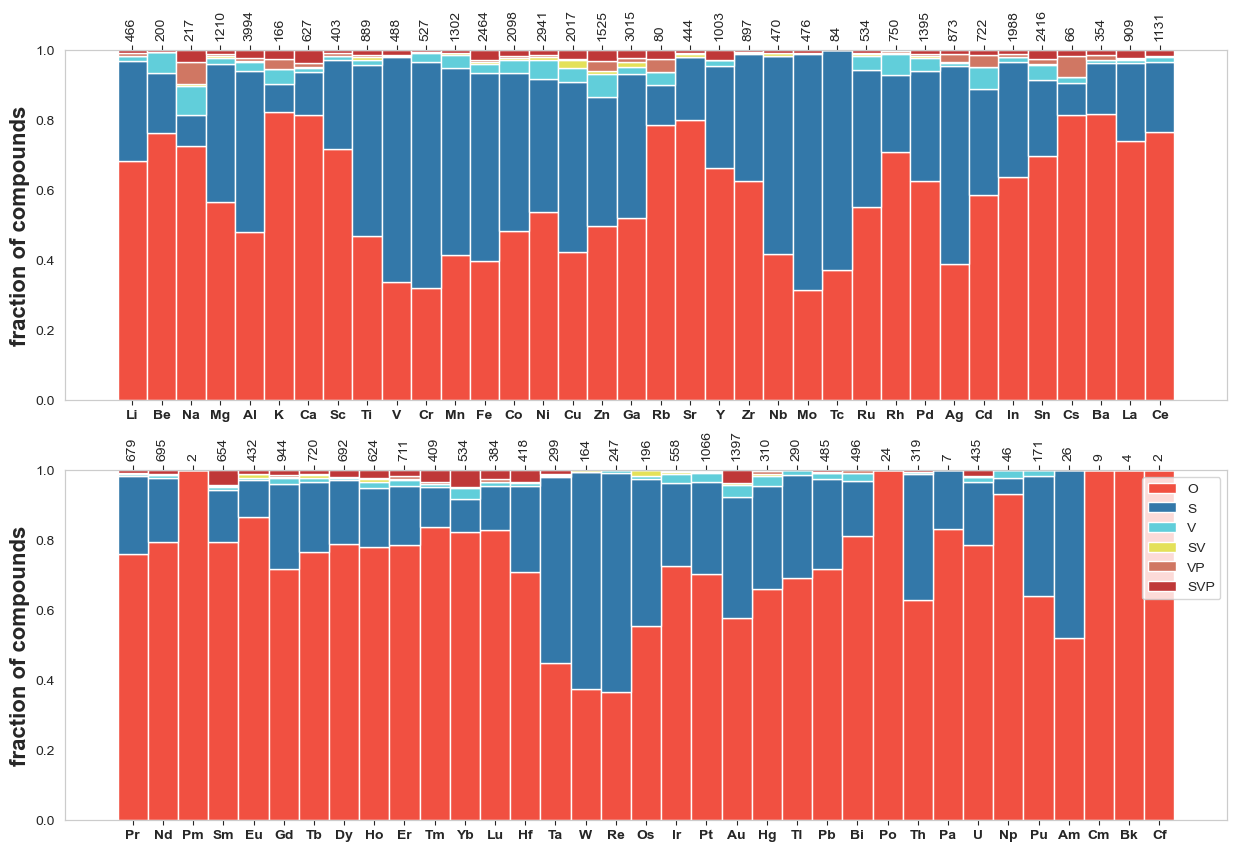

In [410]:
metal_el=['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni',
          'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 
          'In', 'Sn', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
          'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 
          'Bi', 'Po', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

len(metal_el)

ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el not in metal_el):
                switch=1
    if(switch==0):
        ind.append(i)

intermetallics=dbmax_struct.iloc[ind]
print(len(intermetallics))

elem_disorder, elem_disorder_frac=calculate_elements(metal_el,intermetallics)

plot_elements(elem_disorder_frac, filename='images/intermetallics.png',n=36,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

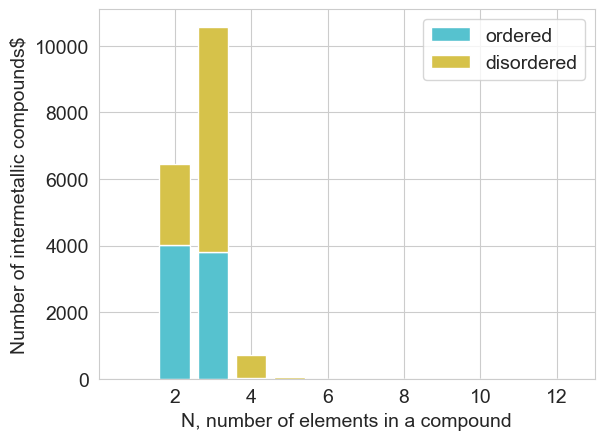

In [424]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=intermetallics.loc[intermetallics['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o))
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d))
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)

plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(86/256,195/256,208/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(215/256, 195/256, 74/256))
plt.xlabel('N, number of elements in a compound',fontsize=14)
plt.ylabel('Number of intermetallic compounds$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
# plt.yscale('log')
plt.legend(fontsize=14)
# plt.savefig('images/comp_distr-mesh.png', transparent=None, dpi=400, format='png')
plt.show()

In [425]:
ordered_n

[0, 4022, 3794, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [426]:
disordered_n

[0, 2443, 6780, 703, 38, 3, 1, 6, 0, 0, 0, 0, 0, 0]

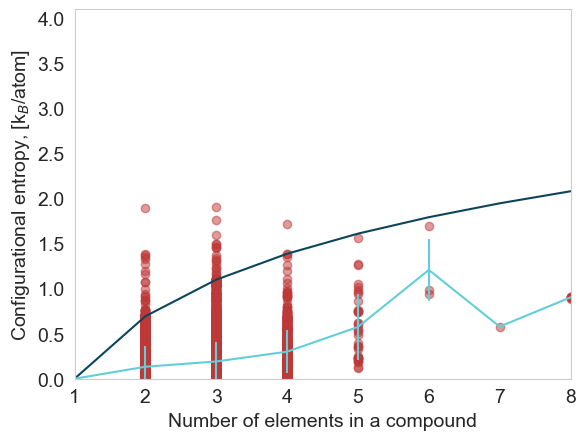

In [430]:
means=[0]
stds=[0]

intermetallics=intermetallics.loc[~intermetallics['entropy'].isna()]
intermetallics=intermetallics.loc[intermetallics['entropy']<100]
intermetallics=intermetallics.loc[intermetallics['entropy']>=0]
for n in range(2,31):
    ent=intermetallics.loc[intermetallics['num_el']==n]['entropy'].values
    means.append(np.mean(ent))
    stds.append(np.std(ent))

plt.scatter(intermetallics['num_el'], intermetallics['entropy'], alpha=0.5,color=(192/256, 56/256, 56/256))
plt.errorbar(np.linspace(1,30,30), means, yerr=stds, alpha=1,color=(97/256, 207/256, 219/256))

# plt.bar(np.linspace(1,14,14), stds, alpha=0.5, width=0.3)
plt.plot(np.linspace(1,30,30), np.log(np.linspace(1,30,30)),color=(11/256, 69/256, 92/256))

plt.xlim(1,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
plt.ylim(0,4.1)
plt.xlabel('Number of elements in a compound',fontsize=14)
plt.ylabel('Configurational entropy, [k$_B$/atom]', fontsize=14)
plt.grid(visible=False)
# plt.savefig('images/entropy-num-elem.png', transparent=None, dpi=400, format='png')
plt.show()

# Substitutional disorder

In [236]:
# Modified Pettifor
mendeleev={'He':1, "Ne":2, 'Ar':3, 'Kr':4, 'Xe':5, 'Rn': 6, 'Fr':7,'Cs':8, 'Rb':9,'K':10,
          'Na':11,'Li':12,'Ra':13,'Ba':14,'Sr':15,'Ca':16,'Eu':17,'Yb':18,'Lu':19,'Tm':20,
          'Y':21,'Er':22, 'Ho':23, 'Dy':24, 'Tb':25,'Gd':26,'Sm':27,'Pm':28,'Nd':29,'Pr':30,
          'Ce':31,'La':32,'Ac':33, 'Th':34, 'Pa':35, 'U':36, 'Np':37, 'Pu':38, 'Am':39, 'Cm':40,
          'Bk':41,'Cf':42,'Es':43, 'Fm':44, 'Sc':45,'Zr':46,'Hf':47,'Ti':48,'Ta':49,'Nb':50,
          'V':51,'Cr':52,'Mo':53,'W':54,'Re':55,'Tc':56,'Os':57, 'Ru':58,'Ir':59,'Rh':60,
          'Pt':61,'Pd':62, 'Au':63, 'Ag':64, 'Cu':65,'Ni':66,'Co':67,'Fe':68,'Mn':69,'Mg':70,
          'Zn':71,'Cd':72,'Hg':73,'Be':74, 'Al':75,'Ga':76,'In':77,'Tl':78,'Pb':79,'Sn':80,
          'Ge':81,'Si':82,'B':83, 'C':84,'N':85,'P':86,'As':87,'Sb':88,'Bi':89,'Po':90,
          'Te':91,'Se':92,'S':93,'O':94,'At':95,'I':96,'Br':97,'Cl':98,'F':99,'H':100}

men=pd.DataFrame.from_dict(mendeleev,orient='index').sort_values(by=0)

In [241]:
do=dbmax_struct.loc[dbmax_struct['disorder_set']=={'O'}]
ds=dbmax_struct.loc[dbmax_struct['disorder_set'].isin([{'S'}, {'O','S'}])]

do2=do.loc[do['num_el']==2]
ds2=ds.loc[ds['num_el']==2]

do2.reset_index(drop=True,inplace=True)
ds2.reset_index(drop=True,inplace=True)

In [246]:
from pymatgen.core.composition import Composition

MA=[]
MB=[]
exceptions=[]

for i in range(len(do2)):
    try:
        comp=Composition(do2['formula'][i])
        if(str(comp.elements[0]) in mendeleev.keys() 
           and str(comp.elements[1]) in mendeleev.keys()):
            x1=comp.get_atomic_fraction(comp.elements[0])
            x2=comp.get_atomic_fraction(comp.elements[1])
            if(x1>x2):
                MA.append(mendeleev[str(comp.elements[0])])
                MB.append(mendeleev[str(comp.elements[1])])
            else:
                MA.append(mendeleev[str(comp.elements[1])])
                MB.append(mendeleev[str(comp.elements[0])])
        else:
            exceptions.append(i)
    except:
        exceptions.append(i)

print(len(do2),len(MA),len(MB),len(exceptions))

do2.drop(index=exceptions,inplace=True)
do2['MA']=MA
do2['MB']=MB

8161 8161 8161 0


/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/700066472.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/700066472.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/700066472.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [248]:
from pymatgen.core.composition import Composition

MA=[]
MB=[]
exceptions=[]

for i in range(len(ds2)):
    try:
        comp=Composition(ds2['formula'][i])
        if(str(comp.elements[0]) in mendeleev.keys() 
           and str(comp.elements[1]) in mendeleev.keys()):
            x1=comp.get_atomic_fraction(comp.elements[0])
            x2=comp.get_atomic_fraction(comp.elements[1])
            if(x1>x2):
                MA.append(mendeleev[str(comp.elements[0])])
                MB.append(mendeleev[str(comp.elements[1])])
            else:
                MA.append(mendeleev[str(comp.elements[1])])
                MB.append(mendeleev[str(comp.elements[0])])
        else:
            exceptions.append(i)
    except:
        exceptions.append(i)
ds2.drop(index=exceptions,inplace=True)
ds2['MA']=MA
ds2['MB']=MB
print(len(ds2),len(MA),len(MB),len(exceptions))

2196 2196 2196 0


/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/982091724.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/982091724.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/982091724.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [249]:
ds2['MA']

0       66
1       53
2       66
3       31
4       61
        ..
2191    68
2192    30
2193    51
2194    22
2195    61
Name: MA, Length: 2196, dtype: int64

In [250]:
colorscale=create_colorscale((27, 54, 87),(242, 80, 65),50)

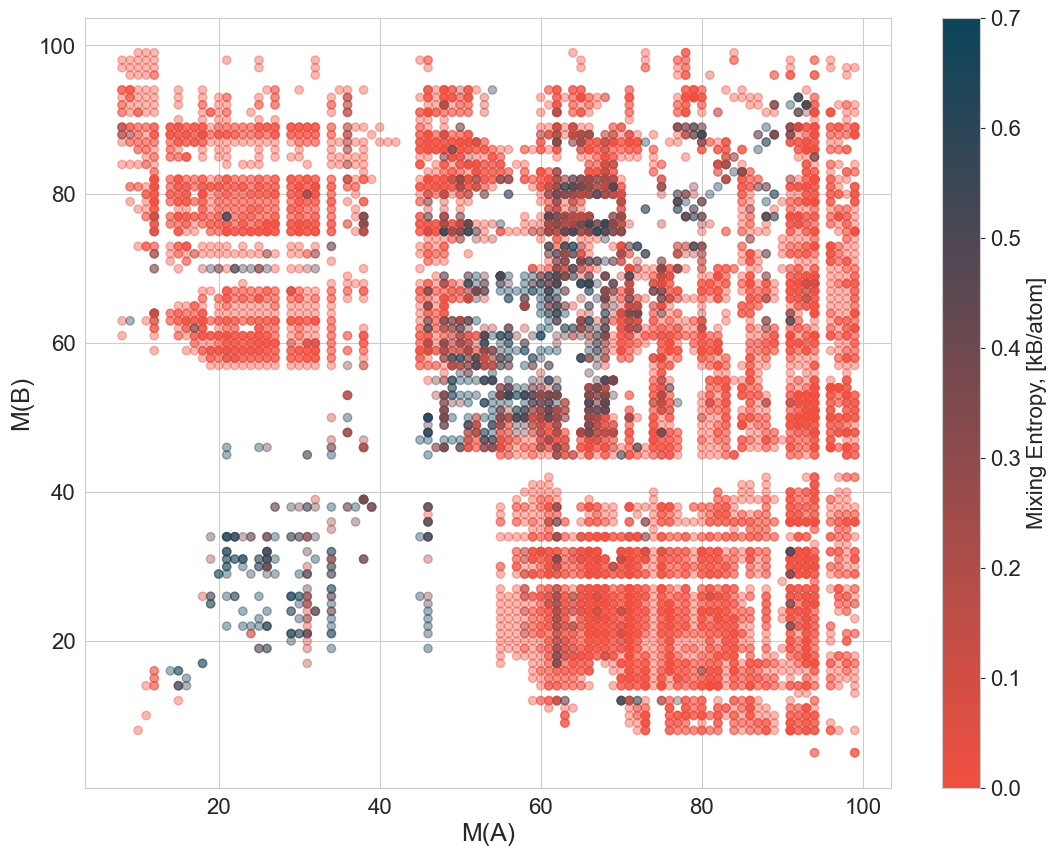

In [254]:
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top=np.ones((256, 4))
bottom=np.ones((128, 4))

top[:,0]=np.linspace(242/256,11/256,256)
top[:,1]=np.linspace(80/256,68/256,256)
top[:,2]=np.linspace(65/256,91/256,256)
# top[:,0]=np.linspace(242/256,97/256,128)
# top[:,1]=np.linspace(80/256,207/256,128)
# top[:,2]=np.linspace(65/256,219/256,128)
# bottom[:,0]=np.linspace(97/256,11/256,1,128)
# bottom[:,1]=np.linspace(207/256,68/256,1,128)
# bottom[:,2]=np.linspace(219/256,91/256,1,128)


# newcolors = np.vstack((top,bottom))
newcolors=top
newcmp = ListedColormap(newcolors, name='OrangeBlue')

cmap =  ListedColormap(newcolors)
norm = mpl.colors.Normalize(vmin=0, vmax=0.7)
plt.figure(figsize=(13,10))
plt.scatter(do2['MA'],do2['MB'],alpha=0.4,c=do2['entropy'],cmap=cmap)
plt.scatter(ds2['MA'],ds2['MB'],alpha=0.4,c=ds2['entropy'],cmap=cmap)
# plt.scatter(dv2['MA'],dv2['MB'],alpha=0.4,c=dv2['mixing_entropy'])
# plt.scatter(dp2['MA'],dp2['MB'],alpha=0.4,c=dp2['mixing_entropy'])
# plt.xticks(np.linspace(1,100,100),men.index,fontsize=5)
# plt.yticks(np.linspace(1,100,100),men.index,fontsize=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('M(A)',fontsize=18)
plt.ylabel('M(B)',fontsize=18)

cmap =  ListedColormap(newcolors)
norm = mpl.colors.Normalize(vmin=0, vmax=0.7)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm,cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='Mixing Entropy, [kB/atom]', size=16)
plt.savefig('images/mixing-entropy-binary.png', transparent=None, dpi=400, format='png',pad_inches='tight')
plt.xticks()
plt.show()

In [261]:
# Modified Pettifor scale from Glawe et al.2016

mendeleev={'He':1, "Ne":2, 'Ar':3, 'Kr':4, 'Xe':5, 'Rn': 6, 'Fr':7,'Cs':8, 'Rb':9,'K':10,
          'Na':11,'Li':12,'Ra':13,'Ba':14,'Sr':15,'Ca':16,'Eu':17,'Yb':18,'Lu':19,'Tm':20,
          'Y':21,'Er':22, 'Ho':23, 'Dy':24, 'Tb':25,'Gd':26,'Sm':27,'Pm':28,'Nd':29,'Pr':30,
          'Ce':31,'La':32,'Ac':33, 'Th':34, 'Pa':35, 'U':36, 'Np':37, 'Pu':38, 'Am':39, 'Cm':40,
          'Bk':41,'Cf':42,'Es':43, 'Fm':44, 'Sc':45,'Zr':46,'Hf':47,'Ti':48,'Ta':49,'Nb':50,
          'V':51,'Cr':52,'Mo':53,'W':54,'Re':55,'Tc':56,'Os':57, 'Ru':58,'Ir':59,'Rh':60,
          'Pt':61,'Pd':62, 'Au':63, 'Ag':64, 'Cu':65,'Ni':66,'Co':67,'Fe':68,'Mn':69,'Mg':70,
          'Zn':71,'Cd':72,'Hg':73,'Be':74, 'Al':75,'Ga':76,'In':77,'Tl':78,'Pb':79,'Sn':80,
          'Ge':81,'Si':82,'B':83, 'C':84,'N':85,'P':86,'As':87,'Sb':88,'Bi':89,'Po':90,
          'Te':91,'Se':92,'S':93,'O':94,'At':95,'I':96,'Br':97,'Cl':98,'F':99,'H':100}

In [262]:
elem_list=list(mendeleev.keys())

In [263]:
orbit_elements=[]
for i in range(len(dbmax_struct)):
    dx=dbmax_struct.iloc[i]
    elem={}
    for j,values in dx['species'].items():
        el=[]
        for sp in values.keys():
            el.append(str(Species(sp).element))
        elem[j]=el
    orbit_elements.append(elem)
dbmax_struct['orbit_elements']=orbit_elements

/var/folders/41/wzm8qn9d6dn8yhp48bnwvj380000gn/T/ipykernel_98395/3988858379.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [264]:
pairs={}
entropies={}
ids={}
for el in elem_list:
    pairs[el]=[]
    entropies[el]=[]
    ids[el]=[]

In [265]:
for i in range(len(dbmax_struct)):
    order=dbmax_struct['orbit_disorder'].values[i].values()
    elem=dbmax_struct['orbit_elements'].values[i]

    for j,orb in enumerate(list(order)):
        if(orb in ['S','SP','SV','SPV']):
#         if(orb in ['S']):
            for el in elem[str(j)]:
                for el1 in elem[str(j)]:
                    if(el1!=el):
#                         if(el=='Al' and el1=='Si'):
#                             ids[el].append(i)
                        pairs[el].append(el1)
                        entropies[el].append(dbmax_struct['entropy'].values[i])

In [266]:
totals={}
for el in elem_list:
    totals[el]=0
    for n in range(len(dbmax_struct)):
        orb_el=dbmax_struct['orbit_elements'].values[n].values()
        switch=0
        for el_l in orb_el:
            if(el in el_l):
                switch=1
        if(switch==1):
            totals[el]+=1

In [267]:
# we normalise by the total number of subtitutional orbits with this element. Maybe need to normalize by the 
# frequencey of another element
pairs1={}
for key,val in pairs.items():
    pairs1[key]={}
    for el in elem_list:
#         if(val.count(el)>0):
        if(totals[el]>0 and totals[key]>0):
            pairs1[key][el]=val.count(el)/totals[el]/totals[key]
        else:
            pairs1[key][el]=0
    s=np.sum(list(pairs1[key].values()))
    if(s>0):
        for el in elem_list:
            pairs1[key][el]=pairs1[key][el]/s

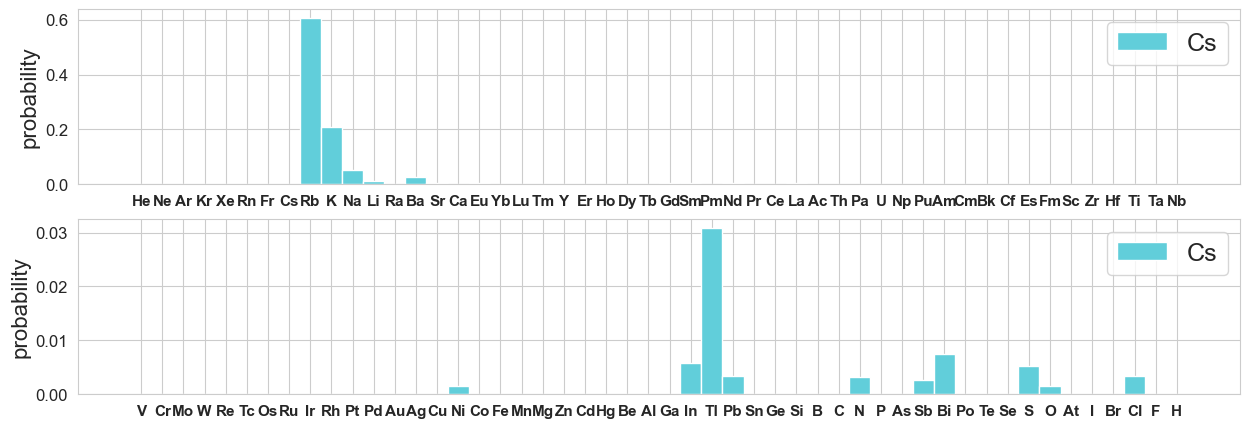

In [271]:
element='Cs'

bars1=[]
names=[]
r=[]
for i,key in enumerate(pairs1[element].keys()):
    names.append(key)
    bars1.append(pairs1[element][key])
    r.append(i)
barWidth = 1

plt.figure(figsize=(15,5))
# Create brown bars
plt.subplot(211)

plt.bar(r[:50], bars1[:50], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label=element)
# (38/256, 157/256, 172/256)(51/256, 133/256, 167/256)
# Custom X axis
plt.xticks(r[:50], names[:50], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
plt.legend(fontsize=18)

plt.subplot(212)
plt.bar(r[50:], bars1[50:], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label=element)

 
# Custom X axis
plt.xticks(r[50:], names[50:], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
# plt.grid(visible=False)

plt.legend(fontsize=18)
plt.savefig('images/Cs-substitution.png', transparent=None, dpi=400, format='png',pad_inches='tight')

plt.show()